In [1]:
%matplotlib inline
import matplotlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
from scipy import ndimage
import os
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
from sklearn.utils import shuffle
import tensorflow.contrib.layers as layers
import tensorflow.contrib.slim as slim
from random import shuffle

In [2]:
total_azimuth_angles = 36
train_split = 0.8
image_H, image_W, image_D = 64,64,3
pose_w, pose_h, pose_d = 4,4,36

In [3]:
dataset = np.load('../../car_64.npy')


1553596416


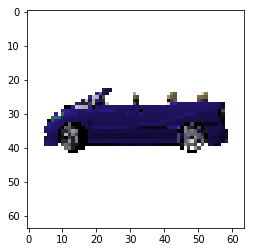

In [4]:
print(dataset.nbytes)
plt.imshow(dataset[711]/255)
plt.show()

In [5]:
 
total_models = dataset.shape[0] // total_azimuth_angles


train_models_len = int(total_models * train_split)
test_models_len = total_models - train_models_len

print(total_models,train_models_len,test_models_len)

3512 2809 703


In [6]:
dataset_train = dataset[:train_models_len*total_azimuth_angles]
dataset_test = dataset[train_models_len*total_azimuth_angles:]

print(dataset_test.shape)
print(dataset_train.shape)

(25308, 64, 64, 3)
(101124, 64, 64, 3)


In [7]:
del dataset
dataset_train.nbytes

1242611712

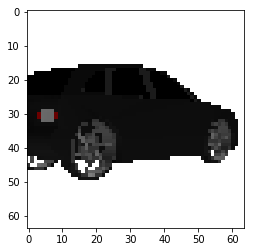

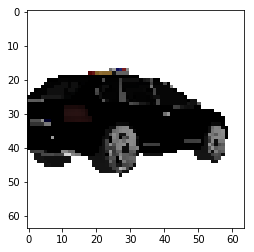

In [8]:
plt.imshow(dataset_train[1023]/255)
plt.show()
plt.imshow(dataset_test[1023]/255)
plt.show()

In [9]:
train_pairs = []
start_pose = [0]
for i in range(train_models_len):
    for j in start_pose:
        for k in range(total_azimuth_angles):
            if j != k:
                train_pairs.append((i,j,k))
                
test_pairs = []
start_pose = [0]
for i in range(test_models_len):
    for j in start_pose:
        for k in range(total_azimuth_angles):
            if j != k:
                test_pairs.append((i,j,k))


In [10]:
print(train_pairs[35])
print(test_pairs[35])
shuffle(train_pairs)
shuffle(test_pairs)
print(train_pairs[35])
print(test_pairs[35])

(1, 0, 1)
(1, 0, 1)
(2747, 0, 18)
(580, 0, 25)


(2098, 0, 13)
(123, 0, 33)
98315


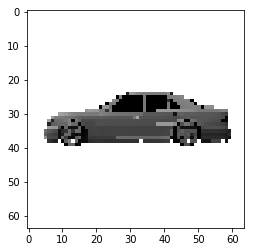

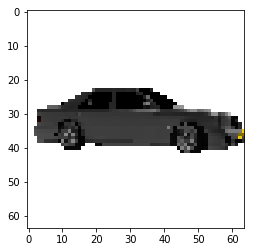

In [11]:
print(train_pairs[0])
print(test_pairs[0])

print(len(train_pairs))

i = dataset_train[(10*36) + 27]
j = dataset_train[(10*36) + 5]
plt.imshow(i/255)
plt.show()
plt.imshow(j/255)
plt.show()

In [12]:
def normalize(data):
    data *= 2.0
    data /= 255.0
    data -= 1.0
    return data

def denormalize(data):
    data = data + 1.0
    data = data * 255.0
    data = data / 2.0
    return data

In [13]:
c = 0
for p in train_pairs:
    if p[0] == 12 and p[1] == 0:
        c += 1
print(c)

35


In [14]:
#pairs (index_no, input, output)
def get_batch_data(pairs, train=True):
    l = train_models_len if train else test_models_len
    d = dataset_train if train else dataset_test
    i, ip, op = 0, 1, 2
    batch, batch_labels, pose = [], [], []
    for p in pairs:
        ip_index = (p[i] * total_azimuth_angles) + p[1]
        batch.append(d[ip_index])
        
        op_index = (p[i] * total_azimuth_angles) + p[2]
        batch_labels.append(d[op_index])
        
        cur_pose =  np.zeros(36, dtype='uint8')
        cur_pose[(p[2] - p[1]) % total_azimuth_angles] = 1
        pose.append(np.broadcast_to(cur_pose,(pose_w, pose_h, pose_d)))
        
    batch = np.array(batch, dtype=np.float64)
    batch_labels = np.array(batch_labels, dtype=np.float64)
    pose = np.array(pose, dtype=np.float64)
    
    #normalize
    batch = normalize(batch)
    batch_labels =  normalize(batch_labels)
    
    return batch,batch_labels,pose

batch, batch_labels, pose_labels = get_batch_data(train_pairs[36:72])

(36, 64, 64, 3) (36, 64, 64, 3) (36, 4, 4, 36)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
<class 'numpy.float64'>
1.0 -1.0


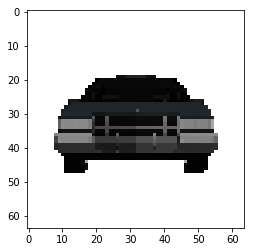

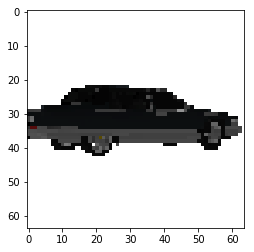

In [15]:
print(batch.shape, batch_labels.shape, pose_labels.shape)

t = 27
print(pose_labels[t][0][0])

print(type(batch_labels[t][0][0][0]))

print(np.max((batch[t])), np.min((batch[t])))

plt.imshow(denormalize(batch[t]) / 255)
plt.show()
plt.imshow(denormalize(batch_labels[t]) / 255)
plt.show()


In [16]:
def lrelu(x, leak=0.2, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)


def conv2d(input, output, kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv2d", act=lrelu):
    #act = tf.nn.leaky_relu
    with tf.variable_scope(scope_name):
        return layers.conv2d(inputs=input, num_outputs=output, kernel_size=[kernel_h, kernel_w], stride=k_stride, activation_fn=act,
         #biases_initializer=tf.zeros_initializer(), weights_initializer=tf.random_normal_initializer(0.0, 0.02))
         biases_initializer=tf.zeros_initializer(), weights_initializer=tf.contrib.layers.xavier_initializer())
    
def deconv2d(input, kernel_size, stride, num_filter, scope_name='deconv2d', act=lrelu):
    with tf.variable_scope(scope_name): 
        stride_shape = [stride, stride]
        kernel_shape = [kernel_size, kernel_size]
        return layers.conv2d_transpose(inputs=input, num_outputs=num_filter, stride=stride_shape, kernel_size= kernel_shape,
            #padding='SAME', biases_initializer=tf.zeros_initializer(), weights_initializer=tf.random_normal_initializer(0.0, 0.02),
            padding='SAME', biases_initializer=tf.zeros_initializer(), weights_initializer=tf.contrib.layers.xavier_initializer(),
            activation_fn=act
        )

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')


def batch_norm(inputs_, is_training):
    out = tf.contrib.layers.batch_norm(inputs_, decay = 0.99, center = True, scale = True,
                                       is_training = is_training, updates_collections = None)
    return out

def fc(input, num_output, name = 'fc'):
    with tf.variable_scope(name):
        num_input = input.get_shape()[1]
        W = tf.get_variable('w', [num_input, num_output], tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [num_output], initializer = tf.constant_initializer(0.0))
        return tf.matmul(input, W) + b

def l1_loss(inputs_, targets_):
    loss = tf.reduce_mean(abs(inputs_ - targets_))
    return loss

def ce_loss(labels, logits):
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
    return tf.reduce_mean(loss)

def local_moment_loss(pred, gt):
    with tf.name_scope('local_moment_loss'):

        ksz, kst = 4, 2
        local_patch = tf.ones((ksz, ksz, 1, 1))
        c = pred.get_shape()[-1]

        # Normalize by kernel size
        pr_mean = tf.concat([tf.nn.conv2d(x, local_patch, strides=[1, kst, kst, 1], padding='VALID') for x in tf.split(pred, c, axis=3)], axis=3)
        pr_var = tf.concat([tf.nn.conv2d(tf.square(x), local_patch, strides=[1, kst, kst, 1], padding='VALID') for x in tf.split(pred, c, axis=3)], axis=3)
        pr_var = (pr_var - tf.square(pr_mean)/(ksz**2)) / (ksz ** 2)
        pr_mean = pr_mean / (ksz ** 2)

        gt_mean = tf.concat([tf.nn.conv2d(x, local_patch, strides=[1, kst, kst, 1], padding='VALID') for x in tf.split(gt, c, axis=3)], axis=3)
        gt_var = tf.concat([tf.nn.conv2d(tf.square(x), local_patch, strides=[1, kst, kst, 1], padding='VALID') for x in tf.split(gt, c, axis=3)], axis=3)
        gt_var = (gt_var - tf.square(gt_mean)/(ksz**2)) / (ksz ** 2)
        gt_mean = gt_mean / (ksz ** 2)

        # scaling by local patch size
        local_mean_loss = tf.reduce_mean(tf.abs(pr_mean - gt_mean))
        local_var_loss = tf.reduce_mean(tf.abs(pr_var - gt_var))
    return local_mean_loss + local_var_loss
    

In [17]:
tf.reset_default_graph()

In [18]:
batch_size = 36
# tf Graph input (only pictures)
inputs_ = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="input")
targets_ = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="target")
pose_ = tf.placeholder(tf.float32, (batch_size, pose_w, pose_h, pose_d), name="pose")

In [19]:

#generate coarse images from inputs_
def auto_encoder(inputs_, pose_):

    with tf.variable_scope('encoder'):

        _ = conv2d(inputs_, output=32 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv1",act=lrelu)
        
        _ = batch_norm(_, True)
        _ = conv2d(_, output=48 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv2",act=lrelu)
        _ = batch_norm(_, True)
        _ = conv2d(_, output=64 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv3",act=lrelu)
        _ = batch_norm(_, True)
        _ = conv2d(_, output=92 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv4",act=lrelu)
        _ = tf.concat([pose_, _], 3)
       

        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=64, scope_name='deconv1',act=lrelu)
        #_ = deconv2d(_, kernel_size=3, stride=2, num_filter=64, scope_name='deconv2',act=lrelu)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=32, scope_name='deconv2',act=lrelu)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=16, scope_name='deconv3',act=lrelu)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=3, scope_name='deconv4',act=None)
        print("O1", _.get_shape())
        _ = tf.nn.tanh(_)
    return _ 


In [20]:
global_step = tf.Variable(0,trainable=False)
lr = 5e-4

In [21]:
global_step = tf.Variable(0,trainable=False)
lr = tf.train.exponential_decay(lr, global_step, 1000, 0.96, staircase=True)
optimizer = tf.train.AdamOptimizer(lr)
res = auto_encoder(inputs_, pose_)
loss_op = l1_loss(res, targets_)

gradients, variables = zip(*optimizer.compute_gradients(loss_op))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
train_op = optimizer.apply_gradients(zip(gradients, variables))


O1 (36, 64, 64, 3)


Epoch: 1/200... Training loss: 0.1930
Epoch: 1/200... Training loss: 0.1808
Epoch: 1/200... Training loss: 0.1779
Epoch: 1/200... Training loss: 0.1717
Epoch: 1/200... Training loss: 0.1597
Epoch: 1/200... Training loss: 0.1571
Epoch: 1/200... Training loss: 0.1444
Epoch: 1/200... Training loss: 0.1450
Epoch: 1/200... Training loss: 0.1470
Epoch: 1/200... Training loss: 0.1345
Epoch: 1/200... Training loss: 0.1318
Epoch: 1/200... Training loss: 0.1332
Epoch: 1/200... Training loss: 0.1188
Epoch: 1/200... Training loss: 0.1107
Epoch: 1/200... Training loss: 0.1180
Epoch: 1/200... Training loss: 0.1142
Epoch: 1/200... Training loss: 0.1164
Epoch: 1/200... Training loss: 0.1156
Epoch: 1/200... Training loss: 0.1158
Epoch: 1/200... Training loss: 0.1132
Epoch: 1/200... Training loss: 0.1150
Epoch: 1/200... Training loss: 0.1188
Epoch: 1/200... Training loss: 0.1146
Epoch: 1/200... Training loss: 0.1013
Epoch: 1/200... Training loss: 0.1161
Epoch: 1/200... Training loss: 0.1059
Epoch: 1/200

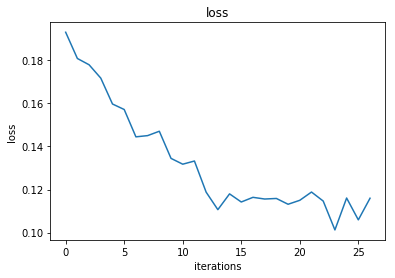

Epoch: 2/200... Training loss: 0.1036
Epoch: 2/200... Training loss: 0.1191
Epoch: 2/200... Training loss: 0.1224
Epoch: 2/200... Training loss: 0.1137
Epoch: 2/200... Training loss: 0.0950
Epoch: 2/200... Training loss: 0.1111
Epoch: 2/200... Training loss: 0.1138
Epoch: 2/200... Training loss: 0.1127
Epoch: 2/200... Training loss: 0.0951
Epoch: 2/200... Training loss: 0.0982
Epoch: 2/200... Training loss: 0.1100
Epoch: 2/200... Training loss: 0.1045
Epoch: 2/200... Training loss: 0.1030
Epoch: 2/200... Training loss: 0.1076
Epoch: 2/200... Training loss: 0.1036
Epoch: 2/200... Training loss: 0.0966
Epoch: 2/200... Training loss: 0.1243
Epoch: 2/200... Training loss: 0.0924
Epoch: 2/200... Training loss: 0.1077
Epoch: 2/200... Training loss: 0.1106
Epoch: 2/200... Training loss: 0.1007
Epoch: 2/200... Training loss: 0.1065
Epoch: 2/200... Training loss: 0.1049
Epoch: 2/200... Training loss: 0.0989
Epoch: 2/200... Training loss: 0.1010
Epoch: 2/200... Training loss: 0.1070
Epoch: 2/200

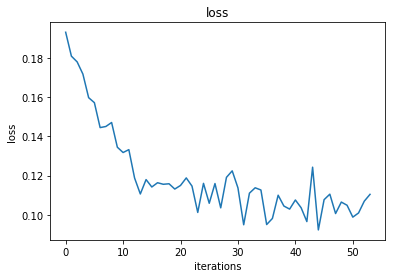

Epoch: 3/200... Training loss: 0.1038
Epoch: 3/200... Training loss: 0.1050
Epoch: 3/200... Training loss: 0.1030
Epoch: 3/200... Training loss: 0.1004
Epoch: 3/200... Training loss: 0.0989
Epoch: 3/200... Training loss: 0.1030
Epoch: 3/200... Training loss: 0.1036
Epoch: 3/200... Training loss: 0.0907
Epoch: 3/200... Training loss: 0.1021
Epoch: 3/200... Training loss: 0.1089
Epoch: 3/200... Training loss: 0.0990
Epoch: 3/200... Training loss: 0.0920
Epoch: 3/200... Training loss: 0.0907
Epoch: 3/200... Training loss: 0.1009
Epoch: 3/200... Training loss: 0.1079
Epoch: 3/200... Training loss: 0.0950
Epoch: 3/200... Training loss: 0.0955
Epoch: 3/200... Training loss: 0.0992
Epoch: 3/200... Training loss: 0.0858
Epoch: 3/200... Training loss: 0.0978
Epoch: 3/200... Training loss: 0.0967
Epoch: 3/200... Training loss: 0.0950
Epoch: 3/200... Training loss: 0.1081
Epoch: 3/200... Training loss: 0.0989
Epoch: 3/200... Training loss: 0.0983
Epoch: 3/200... Training loss: 0.0981
Epoch: 3/200

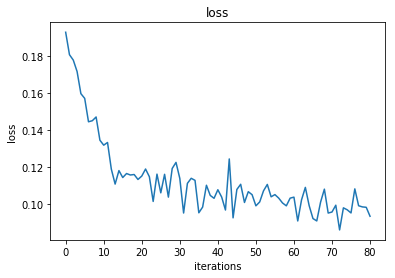

Epoch: 4/200... Training loss: 0.1036
Epoch: 4/200... Training loss: 0.1042
Epoch: 4/200... Training loss: 0.0889
Epoch: 4/200... Training loss: 0.0908
Epoch: 4/200... Training loss: 0.0946
Epoch: 4/200... Training loss: 0.0990
Epoch: 4/200... Training loss: 0.1018
Epoch: 4/200... Training loss: 0.0931
Epoch: 4/200... Training loss: 0.0908
Epoch: 4/200... Training loss: 0.0857
Epoch: 4/200... Training loss: 0.0834
Epoch: 4/200... Training loss: 0.0923
Epoch: 4/200... Training loss: 0.0948
Epoch: 4/200... Training loss: 0.0955
Epoch: 4/200... Training loss: 0.0955
Epoch: 4/200... Training loss: 0.0887
Epoch: 4/200... Training loss: 0.0956
Epoch: 4/200... Training loss: 0.0884
Epoch: 4/200... Training loss: 0.1067
Epoch: 4/200... Training loss: 0.0904
Epoch: 4/200... Training loss: 0.0927
Epoch: 4/200... Training loss: 0.0902
Epoch: 4/200... Training loss: 0.0923
Epoch: 4/200... Training loss: 0.0749
Epoch: 4/200... Training loss: 0.0849
Epoch: 4/200... Training loss: 0.0976
Epoch: 4/200

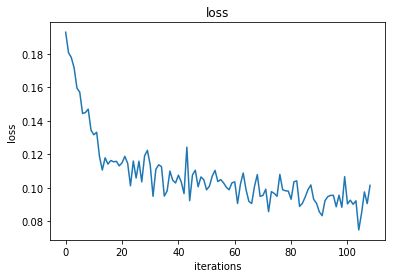

Epoch: 5/200... Training loss: 0.0938
Epoch: 5/200... Training loss: 0.0782
Epoch: 5/200... Training loss: 0.0832
Epoch: 5/200... Training loss: 0.0857
Epoch: 5/200... Training loss: 0.0798
Epoch: 5/200... Training loss: 0.0990
Epoch: 5/200... Training loss: 0.0824
Epoch: 5/200... Training loss: 0.0845
Epoch: 5/200... Training loss: 0.0861
Epoch: 5/200... Training loss: 0.0874
Epoch: 5/200... Training loss: 0.0978
Epoch: 5/200... Training loss: 0.0852
Epoch: 5/200... Training loss: 0.0921
Epoch: 5/200... Training loss: 0.0932
Epoch: 5/200... Training loss: 0.0932
Epoch: 5/200... Training loss: 0.0896
Epoch: 5/200... Training loss: 0.0778
Epoch: 5/200... Training loss: 0.0894
Epoch: 5/200... Training loss: 0.0959
Epoch: 5/200... Training loss: 0.0900
Epoch: 5/200... Training loss: 0.0877
Epoch: 5/200... Training loss: 0.0832
Epoch: 5/200... Training loss: 0.0861
Epoch: 5/200... Training loss: 0.0857
Epoch: 5/200... Training loss: 0.0990
Epoch: 5/200... Training loss: 0.0887
Epoch: 5/200

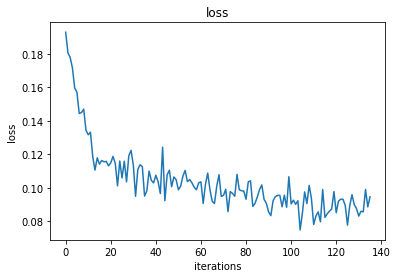

Epoch: 6/200... Training loss: 0.0912
Epoch: 6/200... Training loss: 0.0860
Epoch: 6/200... Training loss: 0.0818
Epoch: 6/200... Training loss: 0.0958
Epoch: 6/200... Training loss: 0.0849
Epoch: 6/200... Training loss: 0.0903
Epoch: 6/200... Training loss: 0.0918
Epoch: 6/200... Training loss: 0.1001
Epoch: 6/200... Training loss: 0.0773
Epoch: 6/200... Training loss: 0.0979
Epoch: 6/200... Training loss: 0.0876
Epoch: 6/200... Training loss: 0.0866
Epoch: 6/200... Training loss: 0.0910
Epoch: 6/200... Training loss: 0.0847
Epoch: 6/200... Training loss: 0.0911
Epoch: 6/200... Training loss: 0.0937
Epoch: 6/200... Training loss: 0.0860
Epoch: 6/200... Training loss: 0.0894
Epoch: 6/200... Training loss: 0.0962
Epoch: 6/200... Training loss: 0.0738
Epoch: 6/200... Training loss: 0.0838
Epoch: 6/200... Training loss: 0.0769
Epoch: 6/200... Training loss: 0.0889
Epoch: 6/200... Training loss: 0.0868
Epoch: 6/200... Training loss: 0.0865
Epoch: 6/200... Training loss: 0.0851
Epoch: 6/200

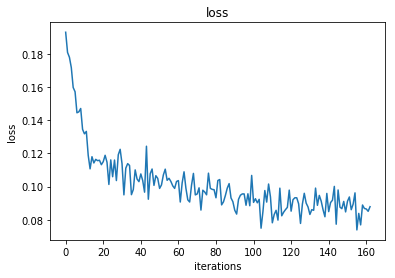

Epoch: 7/200... Training loss: 0.0844
Epoch: 7/200... Training loss: 0.0869
Epoch: 7/200... Training loss: 0.0837
Epoch: 7/200... Training loss: 0.0825
Epoch: 7/200... Training loss: 0.0748
Epoch: 7/200... Training loss: 0.0835
Epoch: 7/200... Training loss: 0.0822
Epoch: 7/200... Training loss: 0.0960
Epoch: 7/200... Training loss: 0.0972
Epoch: 7/200... Training loss: 0.0730
Epoch: 7/200... Training loss: 0.0927
Epoch: 7/200... Training loss: 0.0842
Epoch: 7/200... Training loss: 0.0845
Epoch: 7/200... Training loss: 0.0850
Epoch: 7/200... Training loss: 0.0872
Epoch: 7/200... Training loss: 0.0820
Epoch: 7/200... Training loss: 0.0831
Epoch: 7/200... Training loss: 0.0888
Epoch: 7/200... Training loss: 0.0724
Epoch: 7/200... Training loss: 0.0944
Epoch: 7/200... Training loss: 0.0872
Epoch: 7/200... Training loss: 0.0763
Epoch: 7/200... Training loss: 0.0866
Epoch: 7/200... Training loss: 0.0788
Epoch: 7/200... Training loss: 0.0924
Epoch: 7/200... Training loss: 0.0839
Epoch: 7/200

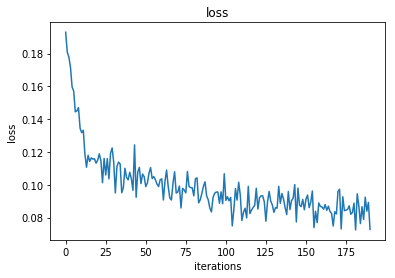

Epoch: 8/200... Training loss: 0.0904
Epoch: 8/200... Training loss: 0.0799
Epoch: 8/200... Training loss: 0.0848
Epoch: 8/200... Training loss: 0.0886
Epoch: 8/200... Training loss: 0.0880
Epoch: 8/200... Training loss: 0.0861
Epoch: 8/200... Training loss: 0.0835
Epoch: 8/200... Training loss: 0.0850
Epoch: 8/200... Training loss: 0.0721
Epoch: 8/200... Training loss: 0.0743
Epoch: 8/200... Training loss: 0.0886
Epoch: 8/200... Training loss: 0.0929
Epoch: 8/200... Training loss: 0.0839
Epoch: 8/200... Training loss: 0.0793
Epoch: 8/200... Training loss: 0.0796
Epoch: 8/200... Training loss: 0.0751
Epoch: 8/200... Training loss: 0.0793
Epoch: 8/200... Training loss: 0.0787
Epoch: 8/200... Training loss: 0.0823
Epoch: 8/200... Training loss: 0.0818
Epoch: 8/200... Training loss: 0.0824
Epoch: 8/200... Training loss: 0.0753
Epoch: 8/200... Training loss: 0.0895
Epoch: 8/200... Training loss: 0.0906
Epoch: 8/200... Training loss: 0.0849
Epoch: 8/200... Training loss: 0.0902
Epoch: 8/200

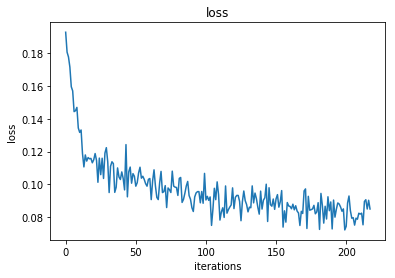

Epoch: 9/200... Training loss: 0.0741
Epoch: 9/200... Training loss: 0.0941
Epoch: 9/200... Training loss: 0.0746
Epoch: 9/200... Training loss: 0.0872
Epoch: 9/200... Training loss: 0.0824
Epoch: 9/200... Training loss: 0.0798
Epoch: 9/200... Training loss: 0.0859
Epoch: 9/200... Training loss: 0.0835
Epoch: 9/200... Training loss: 0.0924
Epoch: 9/200... Training loss: 0.0782
Epoch: 9/200... Training loss: 0.0881
Epoch: 9/200... Training loss: 0.0813
Epoch: 9/200... Training loss: 0.0795
Epoch: 9/200... Training loss: 0.0798
Epoch: 9/200... Training loss: 0.0863
Epoch: 9/200... Training loss: 0.0826
Epoch: 9/200... Training loss: 0.0752
Epoch: 9/200... Training loss: 0.0755
Epoch: 9/200... Training loss: 0.0783
Epoch: 9/200... Training loss: 0.0660
Epoch: 9/200... Training loss: 0.0835
Epoch: 9/200... Training loss: 0.0786
Epoch: 9/200... Training loss: 0.0858
Epoch: 9/200... Training loss: 0.0771
Epoch: 9/200... Training loss: 0.0852
Epoch: 9/200... Training loss: 0.0876
Epoch: 9/200

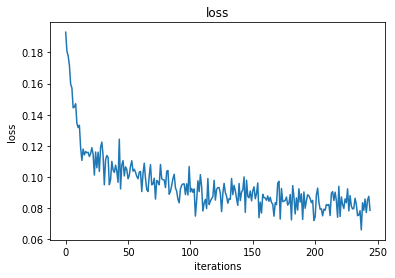

Epoch: 10/200... Training loss: 0.0962
Epoch: 10/200... Training loss: 0.0841
Epoch: 10/200... Training loss: 0.0828
Epoch: 10/200... Training loss: 0.0743
Epoch: 10/200... Training loss: 0.0916
Epoch: 10/200... Training loss: 0.0823
Epoch: 10/200... Training loss: 0.0823
Epoch: 10/200... Training loss: 0.0752
Epoch: 10/200... Training loss: 0.0878
Epoch: 10/200... Training loss: 0.0925
Epoch: 10/200... Training loss: 0.0745
Epoch: 10/200... Training loss: 0.0900
Epoch: 10/200... Training loss: 0.0877
Epoch: 10/200... Training loss: 0.0795
Epoch: 10/200... Training loss: 0.0829
Epoch: 10/200... Training loss: 0.0839
Epoch: 10/200... Training loss: 0.0803
Epoch: 10/200... Training loss: 0.0807
Epoch: 10/200... Training loss: 0.0797
Epoch: 10/200... Training loss: 0.0757
Epoch: 10/200... Training loss: 0.0779
Epoch: 10/200... Training loss: 0.0896
Epoch: 10/200... Training loss: 0.0826
Epoch: 10/200... Training loss: 0.0815
Epoch: 10/200... Training loss: 0.0740
Epoch: 10/200... Training

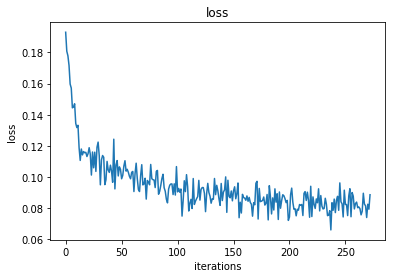

Epoch: 11/200... Training loss: 0.0848
Epoch: 11/200... Training loss: 0.0823
Epoch: 11/200... Training loss: 0.0819
Epoch: 11/200... Training loss: 0.0836
Epoch: 11/200... Training loss: 0.0790
Epoch: 11/200... Training loss: 0.0817
Epoch: 11/200... Training loss: 0.0799
Epoch: 11/200... Training loss: 0.0801
Epoch: 11/200... Training loss: 0.0911
Epoch: 11/200... Training loss: 0.0798
Epoch: 11/200... Training loss: 0.0805
Epoch: 11/200... Training loss: 0.0846
Epoch: 11/200... Training loss: 0.0783
Epoch: 11/200... Training loss: 0.0751
Epoch: 11/200... Training loss: 0.0811
Epoch: 11/200... Training loss: 0.0807
Epoch: 11/200... Training loss: 0.0789
Epoch: 11/200... Training loss: 0.0843
Epoch: 11/200... Training loss: 0.0814
Epoch: 11/200... Training loss: 0.0818
Epoch: 11/200... Training loss: 0.0851
Epoch: 11/200... Training loss: 0.0874
Epoch: 11/200... Training loss: 0.0850
Epoch: 11/200... Training loss: 0.0754
Epoch: 11/200... Training loss: 0.0838
Epoch: 11/200... Training

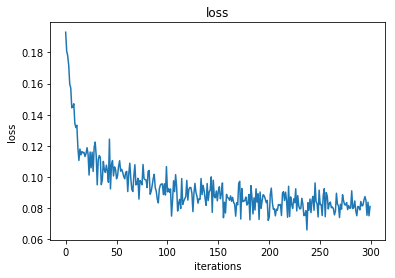

Epoch: 12/200... Training loss: 0.0752
Epoch: 12/200... Training loss: 0.0891
Epoch: 12/200... Training loss: 0.0839
Epoch: 12/200... Training loss: 0.0884
Epoch: 12/200... Training loss: 0.0677
Epoch: 12/200... Training loss: 0.0806
Epoch: 12/200... Training loss: 0.0857
Epoch: 12/200... Training loss: 0.0850
Epoch: 12/200... Training loss: 0.0719
Epoch: 12/200... Training loss: 0.0778
Epoch: 12/200... Training loss: 0.0847
Epoch: 12/200... Training loss: 0.0788
Epoch: 12/200... Training loss: 0.0814
Epoch: 12/200... Training loss: 0.0784
Epoch: 12/200... Training loss: 0.0816
Epoch: 12/200... Training loss: 0.0718
Epoch: 12/200... Training loss: 0.0959
Epoch: 12/200... Training loss: 0.0727
Epoch: 12/200... Training loss: 0.0849
Epoch: 12/200... Training loss: 0.0813
Epoch: 12/200... Training loss: 0.0799
Epoch: 12/200... Training loss: 0.0795
Epoch: 12/200... Training loss: 0.0805
Epoch: 12/200... Training loss: 0.0787
Epoch: 12/200... Training loss: 0.0792
Epoch: 12/200... Training

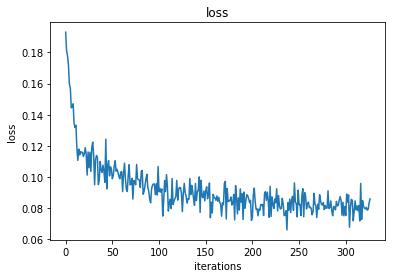

Epoch: 13/200... Training loss: 0.0807
Epoch: 13/200... Training loss: 0.0820
Epoch: 13/200... Training loss: 0.0822
Epoch: 13/200... Training loss: 0.0773
Epoch: 13/200... Training loss: 0.0788
Epoch: 13/200... Training loss: 0.0805
Epoch: 13/200... Training loss: 0.0826
Epoch: 13/200... Training loss: 0.0763
Epoch: 13/200... Training loss: 0.0837
Epoch: 13/200... Training loss: 0.0869
Epoch: 13/200... Training loss: 0.0777
Epoch: 13/200... Training loss: 0.0726
Epoch: 13/200... Training loss: 0.0723
Epoch: 13/200... Training loss: 0.0844
Epoch: 13/200... Training loss: 0.0855
Epoch: 13/200... Training loss: 0.0745
Epoch: 13/200... Training loss: 0.0770
Epoch: 13/200... Training loss: 0.0823
Epoch: 13/200... Training loss: 0.0689
Epoch: 13/200... Training loss: 0.0790
Epoch: 13/200... Training loss: 0.0799
Epoch: 13/200... Training loss: 0.0775
Epoch: 13/200... Training loss: 0.0854
Epoch: 13/200... Training loss: 0.0836
Epoch: 13/200... Training loss: 0.0754
Epoch: 13/200... Training

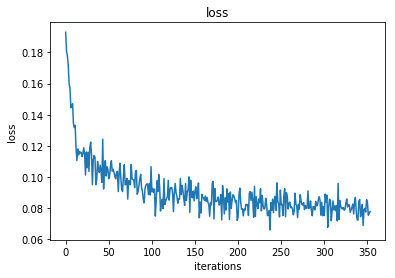

Epoch: 14/200... Training loss: 0.0808
Epoch: 14/200... Training loss: 0.0828
Epoch: 14/200... Training loss: 0.0722
Epoch: 14/200... Training loss: 0.0746
Epoch: 14/200... Training loss: 0.0806
Epoch: 14/200... Training loss: 0.0829
Epoch: 14/200... Training loss: 0.0870
Epoch: 14/200... Training loss: 0.0804
Epoch: 14/200... Training loss: 0.0776
Epoch: 14/200... Training loss: 0.0702
Epoch: 14/200... Training loss: 0.0703
Epoch: 14/200... Training loss: 0.0793
Epoch: 14/200... Training loss: 0.0798
Epoch: 14/200... Training loss: 0.0807
Epoch: 14/200... Training loss: 0.0817
Epoch: 14/200... Training loss: 0.0749
Epoch: 14/200... Training loss: 0.0812
Epoch: 14/200... Training loss: 0.0747
Epoch: 14/200... Training loss: 0.0906
Epoch: 14/200... Training loss: 0.0788
Epoch: 14/200... Training loss: 0.0821
Epoch: 14/200... Training loss: 0.0775
Epoch: 14/200... Training loss: 0.0776
Epoch: 14/200... Training loss: 0.0646
Epoch: 14/200... Training loss: 0.0719
Epoch: 14/200... Training

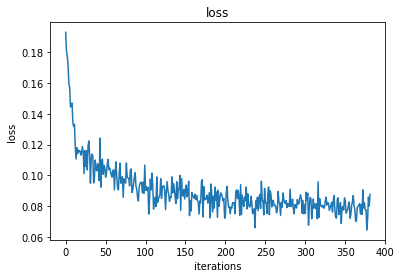

Epoch: 15/200... Training loss: 0.0808
Epoch: 15/200... Training loss: 0.0682
Epoch: 15/200... Training loss: 0.0716
Epoch: 15/200... Training loss: 0.0748
Epoch: 15/200... Training loss: 0.0694
Epoch: 15/200... Training loss: 0.0855
Epoch: 15/200... Training loss: 0.0713
Epoch: 15/200... Training loss: 0.0728
Epoch: 15/200... Training loss: 0.0761
Epoch: 15/200... Training loss: 0.0778
Epoch: 15/200... Training loss: 0.0870
Epoch: 15/200... Training loss: 0.0729
Epoch: 15/200... Training loss: 0.0819
Epoch: 15/200... Training loss: 0.0815
Epoch: 15/200... Training loss: 0.0829
Epoch: 15/200... Training loss: 0.0789
Epoch: 15/200... Training loss: 0.0687
Epoch: 15/200... Training loss: 0.0783
Epoch: 15/200... Training loss: 0.0841
Epoch: 15/200... Training loss: 0.0790
Epoch: 15/200... Training loss: 0.0769
Epoch: 15/200... Training loss: 0.0740
Epoch: 15/200... Training loss: 0.0765
Epoch: 15/200... Training loss: 0.0755
Epoch: 15/200... Training loss: 0.0872
Epoch: 15/200... Training

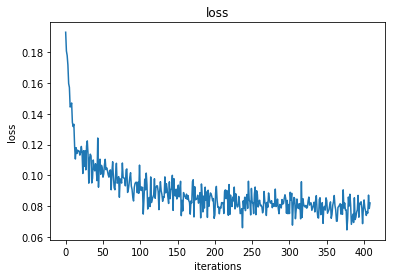

Epoch: 16/200... Training loss: 0.0831
Epoch: 16/200... Training loss: 0.0736
Epoch: 16/200... Training loss: 0.0748
Epoch: 16/200... Training loss: 0.0871
Epoch: 16/200... Training loss: 0.0768
Epoch: 16/200... Training loss: 0.0795
Epoch: 16/200... Training loss: 0.0807
Epoch: 16/200... Training loss: 0.0901
Epoch: 16/200... Training loss: 0.0701
Epoch: 16/200... Training loss: 0.0887
Epoch: 16/200... Training loss: 0.0790
Epoch: 16/200... Training loss: 0.0778
Epoch: 16/200... Training loss: 0.0838
Epoch: 16/200... Training loss: 0.0760
Epoch: 16/200... Training loss: 0.0814
Epoch: 16/200... Training loss: 0.0859
Epoch: 16/200... Training loss: 0.0771
Epoch: 16/200... Training loss: 0.0796
Epoch: 16/200... Training loss: 0.0869
Epoch: 16/200... Training loss: 0.0682
Epoch: 16/200... Training loss: 0.0745
Epoch: 16/200... Training loss: 0.0708
Epoch: 16/200... Training loss: 0.0818
Epoch: 16/200... Training loss: 0.0783
Epoch: 16/200... Training loss: 0.0777
Epoch: 16/200... Training

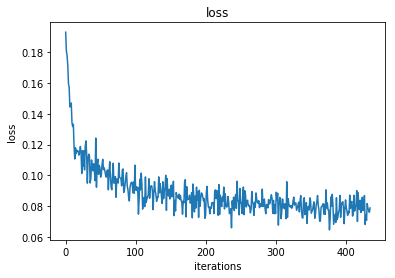

Epoch: 17/200... Training loss: 0.0765
Epoch: 17/200... Training loss: 0.0773
Epoch: 17/200... Training loss: 0.0749
Epoch: 17/200... Training loss: 0.0748
Epoch: 17/200... Training loss: 0.0696
Epoch: 17/200... Training loss: 0.0751
Epoch: 17/200... Training loss: 0.0765
Epoch: 17/200... Training loss: 0.0881
Epoch: 17/200... Training loss: 0.0889
Epoch: 17/200... Training loss: 0.0669
Epoch: 17/200... Training loss: 0.0861
Epoch: 17/200... Training loss: 0.0783
Epoch: 17/200... Training loss: 0.0782
Epoch: 17/200... Training loss: 0.0783
Epoch: 17/200... Training loss: 0.0805
Epoch: 17/200... Training loss: 0.0760
Epoch: 17/200... Training loss: 0.0765
Epoch: 17/200... Training loss: 0.0812
Epoch: 17/200... Training loss: 0.0655
Epoch: 17/200... Training loss: 0.0869
Epoch: 17/200... Training loss: 0.0793
Epoch: 17/200... Training loss: 0.0698
Epoch: 17/200... Training loss: 0.0790
Epoch: 17/200... Training loss: 0.0735
Epoch: 17/200... Training loss: 0.0835
Epoch: 17/200... Training

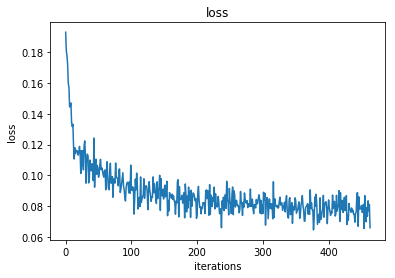

Epoch: 18/200... Training loss: 0.0843
Epoch: 18/200... Training loss: 0.0729
Epoch: 18/200... Training loss: 0.0768
Epoch: 18/200... Training loss: 0.0824
Epoch: 18/200... Training loss: 0.0813
Epoch: 18/200... Training loss: 0.0789
Epoch: 18/200... Training loss: 0.0773
Epoch: 18/200... Training loss: 0.0786
Epoch: 18/200... Training loss: 0.0665
Epoch: 18/200... Training loss: 0.0680
Epoch: 18/200... Training loss: 0.0809
Epoch: 18/200... Training loss: 0.0848
Epoch: 18/200... Training loss: 0.0767
Epoch: 18/200... Training loss: 0.0745
Epoch: 18/200... Training loss: 0.0746
Epoch: 18/200... Training loss: 0.0700
Epoch: 18/200... Training loss: 0.0737
Epoch: 18/200... Training loss: 0.0740
Epoch: 18/200... Training loss: 0.0766
Epoch: 18/200... Training loss: 0.0755
Epoch: 18/200... Training loss: 0.0748
Epoch: 18/200... Training loss: 0.0682
Epoch: 18/200... Training loss: 0.0829
Epoch: 18/200... Training loss: 0.0819
Epoch: 18/200... Training loss: 0.0797
Epoch: 18/200... Training

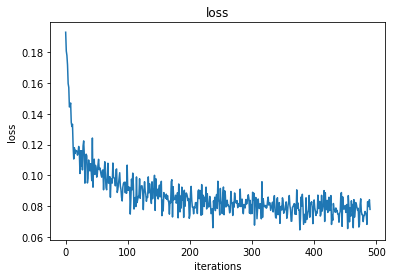

Epoch: 19/200... Training loss: 0.0684
Epoch: 19/200... Training loss: 0.0889
Epoch: 19/200... Training loss: 0.0703
Epoch: 19/200... Training loss: 0.0808
Epoch: 19/200... Training loss: 0.0763
Epoch: 19/200... Training loss: 0.0745
Epoch: 19/200... Training loss: 0.0794
Epoch: 19/200... Training loss: 0.0773
Epoch: 19/200... Training loss: 0.0867
Epoch: 19/200... Training loss: 0.0743
Epoch: 19/200... Training loss: 0.0821
Epoch: 19/200... Training loss: 0.0750
Epoch: 19/200... Training loss: 0.0737
Epoch: 19/200... Training loss: 0.0732
Epoch: 19/200... Training loss: 0.0795
Epoch: 19/200... Training loss: 0.0761
Epoch: 19/200... Training loss: 0.0691
Epoch: 19/200... Training loss: 0.0711
Epoch: 19/200... Training loss: 0.0736
Epoch: 19/200... Training loss: 0.0612
Epoch: 19/200... Training loss: 0.0769
Epoch: 19/200... Training loss: 0.0729
Epoch: 19/200... Training loss: 0.0798
Epoch: 19/200... Training loss: 0.0715
Epoch: 19/200... Training loss: 0.0787
Epoch: 19/200... Training

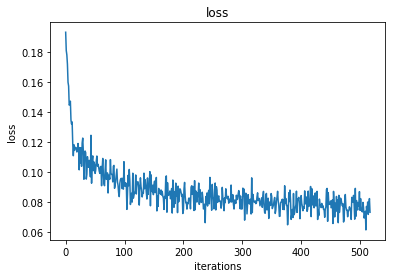

Epoch: 20/200... Training loss: 0.0872
Epoch: 20/200... Training loss: 0.0795
Epoch: 20/200... Training loss: 0.0752
Epoch: 20/200... Training loss: 0.0713
Epoch: 20/200... Training loss: 0.0847
Epoch: 20/200... Training loss: 0.0772
Epoch: 20/200... Training loss: 0.0777
Epoch: 20/200... Training loss: 0.0710
Epoch: 20/200... Training loss: 0.0824
Epoch: 20/200... Training loss: 0.0856
Epoch: 20/200... Training loss: 0.0707
Epoch: 20/200... Training loss: 0.0849
Epoch: 20/200... Training loss: 0.0805
Epoch: 20/200... Training loss: 0.0736
Epoch: 20/200... Training loss: 0.0762
Epoch: 20/200... Training loss: 0.0793
Epoch: 20/200... Training loss: 0.0757
Epoch: 20/200... Training loss: 0.0748
Epoch: 20/200... Training loss: 0.0755
Epoch: 20/200... Training loss: 0.0698
Epoch: 20/200... Training loss: 0.0718
Epoch: 20/200... Training loss: 0.0844
Epoch: 20/200... Training loss: 0.0768
Epoch: 20/200... Training loss: 0.0760
Epoch: 20/200... Training loss: 0.0692
Epoch: 20/200... Training

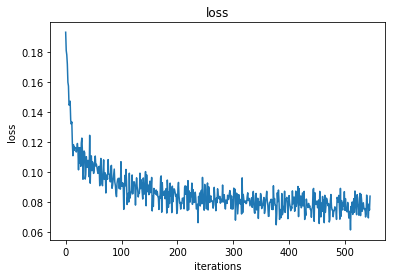

Epoch: 21/200... Training loss: 0.0796
Epoch: 21/200... Training loss: 0.0782
Epoch: 21/200... Training loss: 0.0776
Epoch: 21/200... Training loss: 0.0793
Epoch: 21/200... Training loss: 0.0758
Epoch: 21/200... Training loss: 0.0787
Epoch: 21/200... Training loss: 0.0743
Epoch: 21/200... Training loss: 0.0748
Epoch: 21/200... Training loss: 0.0849
Epoch: 21/200... Training loss: 0.0754
Epoch: 21/200... Training loss: 0.0767
Epoch: 21/200... Training loss: 0.0808
Epoch: 21/200... Training loss: 0.0748
Epoch: 21/200... Training loss: 0.0701
Epoch: 21/200... Training loss: 0.0770
Epoch: 21/200... Training loss: 0.0764
Epoch: 21/200... Training loss: 0.0743
Epoch: 21/200... Training loss: 0.0779
Epoch: 21/200... Training loss: 0.0773
Epoch: 21/200... Training loss: 0.0787
Epoch: 21/200... Training loss: 0.0791
Epoch: 21/200... Training loss: 0.0833
Epoch: 21/200... Training loss: 0.0805
Epoch: 21/200... Training loss: 0.0711
Epoch: 21/200... Training loss: 0.0789
Epoch: 21/200... Training

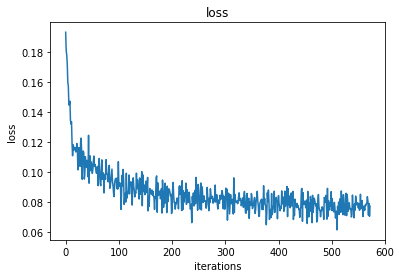

Epoch: 22/200... Training loss: 0.0715
Epoch: 22/200... Training loss: 0.0846
Epoch: 22/200... Training loss: 0.0776
Epoch: 22/200... Training loss: 0.0836
Epoch: 22/200... Training loss: 0.0639
Epoch: 22/200... Training loss: 0.0756
Epoch: 22/200... Training loss: 0.0820
Epoch: 22/200... Training loss: 0.0817
Epoch: 22/200... Training loss: 0.0686
Epoch: 22/200... Training loss: 0.0733
Epoch: 22/200... Training loss: 0.0806
Epoch: 22/200... Training loss: 0.0742
Epoch: 22/200... Training loss: 0.0762
Epoch: 22/200... Training loss: 0.0745
Epoch: 22/200... Training loss: 0.0780
Epoch: 22/200... Training loss: 0.0692
Epoch: 22/200... Training loss: 0.0907
Epoch: 22/200... Training loss: 0.0682
Epoch: 22/200... Training loss: 0.0805
Epoch: 22/200... Training loss: 0.0767
Epoch: 22/200... Training loss: 0.0759
Epoch: 22/200... Training loss: 0.0742
Epoch: 22/200... Training loss: 0.0775
Epoch: 22/200... Training loss: 0.0752
Epoch: 22/200... Training loss: 0.0748
Epoch: 22/200... Training

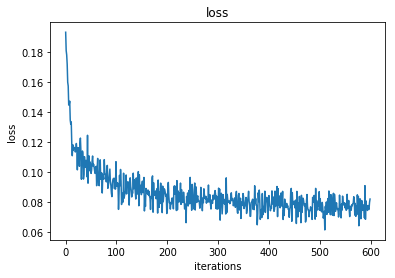

Epoch: 23/200... Training loss: 0.0769
Epoch: 23/200... Training loss: 0.0788
Epoch: 23/200... Training loss: 0.0775
Epoch: 23/200... Training loss: 0.0726
Epoch: 23/200... Training loss: 0.0766
Epoch: 23/200... Training loss: 0.0768
Epoch: 23/200... Training loss: 0.0790
Epoch: 23/200... Training loss: 0.0719
Epoch: 23/200... Training loss: 0.0811
Epoch: 23/200... Training loss: 0.0830
Epoch: 23/200... Training loss: 0.0734
Epoch: 23/200... Training loss: 0.0696
Epoch: 23/200... Training loss: 0.0684
Epoch: 23/200... Training loss: 0.0794
Epoch: 23/200... Training loss: 0.0807
Epoch: 23/200... Training loss: 0.0724
Epoch: 23/200... Training loss: 0.0749
Epoch: 23/200... Training loss: 0.0794
Epoch: 23/200... Training loss: 0.0669
Epoch: 23/200... Training loss: 0.0759
Epoch: 23/200... Training loss: 0.0752
Epoch: 23/200... Training loss: 0.0749
Epoch: 23/200... Training loss: 0.0824
Epoch: 23/200... Training loss: 0.0794
Epoch: 23/200... Training loss: 0.0720
Epoch: 23/200... Training

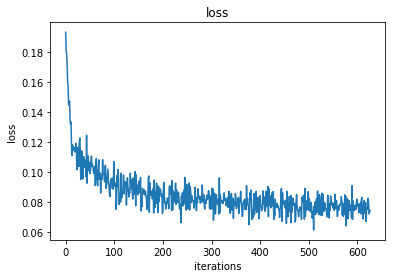

Epoch: 24/200... Training loss: 0.0780
Epoch: 24/200... Training loss: 0.0787
Epoch: 24/200... Training loss: 0.0682
Epoch: 24/200... Training loss: 0.0709
Epoch: 24/200... Training loss: 0.0763
Epoch: 24/200... Training loss: 0.0794
Epoch: 24/200... Training loss: 0.0840
Epoch: 24/200... Training loss: 0.0780
Epoch: 24/200... Training loss: 0.0749
Epoch: 24/200... Training loss: 0.0663
Epoch: 24/200... Training loss: 0.0663
Epoch: 24/200... Training loss: 0.0760
Epoch: 24/200... Training loss: 0.0765
Epoch: 24/200... Training loss: 0.0770
Epoch: 24/200... Training loss: 0.0764
Epoch: 24/200... Training loss: 0.0709
Epoch: 24/200... Training loss: 0.0766
Epoch: 24/200... Training loss: 0.0721
Epoch: 24/200... Training loss: 0.0860
Epoch: 24/200... Training loss: 0.0757
Epoch: 24/200... Training loss: 0.0787
Epoch: 24/200... Training loss: 0.0742
Epoch: 24/200... Training loss: 0.0740
Epoch: 24/200... Training loss: 0.0614
Epoch: 24/200... Training loss: 0.0691
Epoch: 24/200... Training

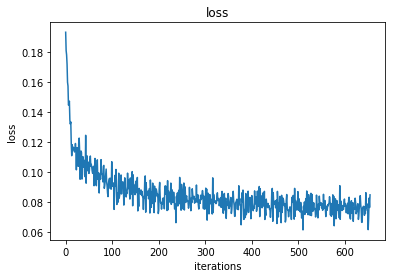

Epoch: 25/200... Training loss: 0.0774
Epoch: 25/200... Training loss: 0.0655
Epoch: 25/200... Training loss: 0.0684
Epoch: 25/200... Training loss: 0.0716
Epoch: 25/200... Training loss: 0.0667
Epoch: 25/200... Training loss: 0.0817
Epoch: 25/200... Training loss: 0.0679
Epoch: 25/200... Training loss: 0.0700
Epoch: 25/200... Training loss: 0.0719
Epoch: 25/200... Training loss: 0.0746
Epoch: 25/200... Training loss: 0.0827
Epoch: 25/200... Training loss: 0.0691
Epoch: 25/200... Training loss: 0.0775
Epoch: 25/200... Training loss: 0.0789
Epoch: 25/200... Training loss: 0.0794
Epoch: 25/200... Training loss: 0.0757
Epoch: 25/200... Training loss: 0.0661
Epoch: 25/200... Training loss: 0.0757
Epoch: 25/200... Training loss: 0.0808
Epoch: 25/200... Training loss: 0.0760
Epoch: 25/200... Training loss: 0.0741
Epoch: 25/200... Training loss: 0.0707
Epoch: 25/200... Training loss: 0.0744
Epoch: 25/200... Training loss: 0.0728
Epoch: 25/200... Training loss: 0.0846
Epoch: 25/200... Training

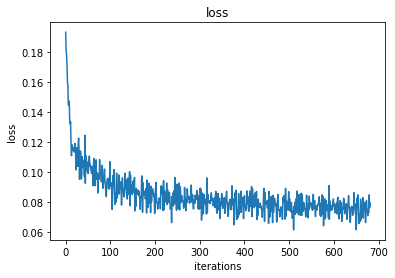

Epoch: 26/200... Training loss: 0.0798
Epoch: 26/200... Training loss: 0.0715
Epoch: 26/200... Training loss: 0.0722
Epoch: 26/200... Training loss: 0.0842
Epoch: 26/200... Training loss: 0.0744
Epoch: 26/200... Training loss: 0.0768
Epoch: 26/200... Training loss: 0.0776
Epoch: 26/200... Training loss: 0.0863
Epoch: 26/200... Training loss: 0.0687
Epoch: 26/200... Training loss: 0.0854
Epoch: 26/200... Training loss: 0.0761
Epoch: 26/200... Training loss: 0.0749
Epoch: 26/200... Training loss: 0.0815
Epoch: 26/200... Training loss: 0.0730
Epoch: 26/200... Training loss: 0.0783
Epoch: 26/200... Training loss: 0.0821
Epoch: 26/200... Training loss: 0.0745
Epoch: 26/200... Training loss: 0.0764
Epoch: 26/200... Training loss: 0.0843
Epoch: 26/200... Training loss: 0.0655
Epoch: 26/200... Training loss: 0.0724
Epoch: 26/200... Training loss: 0.0678
Epoch: 26/200... Training loss: 0.0787
Epoch: 26/200... Training loss: 0.0753
Epoch: 26/200... Training loss: 0.0748
Epoch: 26/200... Training

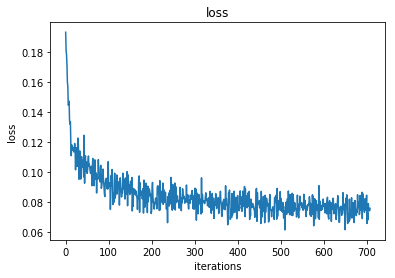

Epoch: 27/200... Training loss: 0.0736
Epoch: 27/200... Training loss: 0.0741
Epoch: 27/200... Training loss: 0.0731
Epoch: 27/200... Training loss: 0.0723
Epoch: 27/200... Training loss: 0.0677
Epoch: 27/200... Training loss: 0.0729
Epoch: 27/200... Training loss: 0.0744
Epoch: 27/200... Training loss: 0.0837
Epoch: 27/200... Training loss: 0.0856
Epoch: 27/200... Training loss: 0.0651
Epoch: 27/200... Training loss: 0.0832
Epoch: 27/200... Training loss: 0.0748
Epoch: 27/200... Training loss: 0.0744
Epoch: 27/200... Training loss: 0.0759
Epoch: 27/200... Training loss: 0.0775
Epoch: 27/200... Training loss: 0.0727
Epoch: 27/200... Training loss: 0.0740
Epoch: 27/200... Training loss: 0.0786
Epoch: 27/200... Training loss: 0.0631
Epoch: 27/200... Training loss: 0.0840
Epoch: 27/200... Training loss: 0.0764
Epoch: 27/200... Training loss: 0.0679
Epoch: 27/200... Training loss: 0.0760
Epoch: 27/200... Training loss: 0.0700
Epoch: 27/200... Training loss: 0.0789
Epoch: 27/200... Training

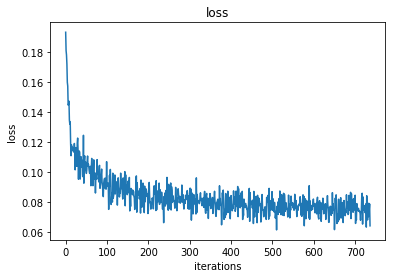

Epoch: 28/200... Training loss: 0.0811
Epoch: 28/200... Training loss: 0.0697
Epoch: 28/200... Training loss: 0.0737
Epoch: 28/200... Training loss: 0.0791
Epoch: 28/200... Training loss: 0.0785
Epoch: 28/200... Training loss: 0.0760
Epoch: 28/200... Training loss: 0.0747
Epoch: 28/200... Training loss: 0.0761
Epoch: 28/200... Training loss: 0.0645
Epoch: 28/200... Training loss: 0.0662
Epoch: 28/200... Training loss: 0.0787
Epoch: 28/200... Training loss: 0.0821
Epoch: 28/200... Training loss: 0.0735
Epoch: 28/200... Training loss: 0.0729
Epoch: 28/200... Training loss: 0.0717
Epoch: 28/200... Training loss: 0.0676
Epoch: 28/200... Training loss: 0.0723
Epoch: 28/200... Training loss: 0.0722
Epoch: 28/200... Training loss: 0.0745
Epoch: 28/200... Training loss: 0.0732
Epoch: 28/200... Training loss: 0.0724
Epoch: 28/200... Training loss: 0.0665
Epoch: 28/200... Training loss: 0.0798
Epoch: 28/200... Training loss: 0.0789
Epoch: 28/200... Training loss: 0.0773
Epoch: 28/200... Training

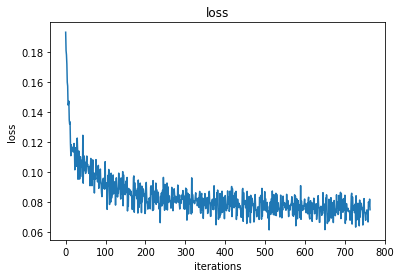

Epoch: 29/200... Training loss: 0.0668
Epoch: 29/200... Training loss: 0.0860
Epoch: 29/200... Training loss: 0.0686
Epoch: 29/200... Training loss: 0.0782
Epoch: 29/200... Training loss: 0.0744
Epoch: 29/200... Training loss: 0.0723
Epoch: 29/200... Training loss: 0.0772
Epoch: 29/200... Training loss: 0.0749
Epoch: 29/200... Training loss: 0.0843
Epoch: 29/200... Training loss: 0.0717
Epoch: 29/200... Training loss: 0.0783
Epoch: 29/200... Training loss: 0.0725
Epoch: 29/200... Training loss: 0.0716
Epoch: 29/200... Training loss: 0.0709
Epoch: 29/200... Training loss: 0.0769
Epoch: 29/200... Training loss: 0.0741
Epoch: 29/200... Training loss: 0.0677
Epoch: 29/200... Training loss: 0.0692
Epoch: 29/200... Training loss: 0.0718
Epoch: 29/200... Training loss: 0.0593
Epoch: 29/200... Training loss: 0.0739
Epoch: 29/200... Training loss: 0.0711
Epoch: 29/200... Training loss: 0.0770
Epoch: 29/200... Training loss: 0.0702
Epoch: 29/200... Training loss: 0.0766
Epoch: 29/200... Training

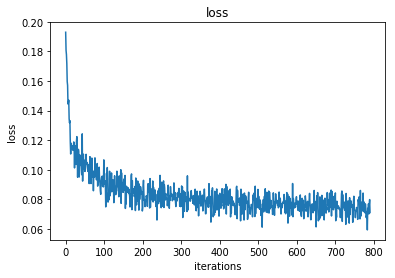

Epoch: 30/200... Training loss: 0.0842
Epoch: 30/200... Training loss: 0.0769
Epoch: 30/200... Training loss: 0.0735
Epoch: 30/200... Training loss: 0.0693
Epoch: 30/200... Training loss: 0.0823
Epoch: 30/200... Training loss: 0.0751
Epoch: 30/200... Training loss: 0.0749
Epoch: 30/200... Training loss: 0.0696
Epoch: 30/200... Training loss: 0.0800
Epoch: 30/200... Training loss: 0.0832
Epoch: 30/200... Training loss: 0.0683
Epoch: 30/200... Training loss: 0.0829
Epoch: 30/200... Training loss: 0.0782
Epoch: 30/200... Training loss: 0.0715
Epoch: 30/200... Training loss: 0.0746
Epoch: 30/200... Training loss: 0.0768
Epoch: 30/200... Training loss: 0.0741
Epoch: 30/200... Training loss: 0.0726
Epoch: 30/200... Training loss: 0.0743
Epoch: 30/200... Training loss: 0.0680
Epoch: 30/200... Training loss: 0.0696
Epoch: 30/200... Training loss: 0.0815
Epoch: 30/200... Training loss: 0.0750
Epoch: 30/200... Training loss: 0.0737
Epoch: 30/200... Training loss: 0.0676
Epoch: 30/200... Training

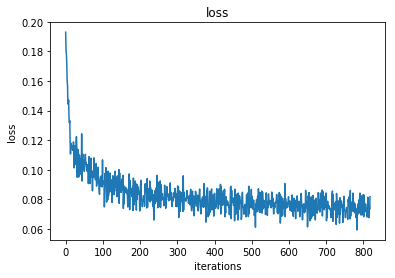

Epoch: 31/200... Training loss: 0.0764
Epoch: 31/200... Training loss: 0.0765
Epoch: 31/200... Training loss: 0.0755
Epoch: 31/200... Training loss: 0.0768
Epoch: 31/200... Training loss: 0.0735
Epoch: 31/200... Training loss: 0.0767
Epoch: 31/200... Training loss: 0.0729
Epoch: 31/200... Training loss: 0.0735
Epoch: 31/200... Training loss: 0.0833
Epoch: 31/200... Training loss: 0.0743
Epoch: 31/200... Training loss: 0.0753
Epoch: 31/200... Training loss: 0.0785
Epoch: 31/200... Training loss: 0.0727
Epoch: 31/200... Training loss: 0.0688
Epoch: 31/200... Training loss: 0.0752
Epoch: 31/200... Training loss: 0.0748
Epoch: 31/200... Training loss: 0.0732
Epoch: 31/200... Training loss: 0.0753
Epoch: 31/200... Training loss: 0.0766
Epoch: 31/200... Training loss: 0.0764
Epoch: 31/200... Training loss: 0.0763
Epoch: 31/200... Training loss: 0.0812
Epoch: 31/200... Training loss: 0.0790
Epoch: 31/200... Training loss: 0.0692
Epoch: 31/200... Training loss: 0.0777
Epoch: 31/200... Training

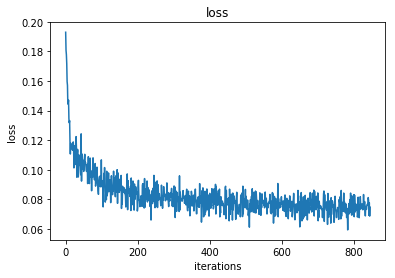

Epoch: 32/200... Training loss: 0.0688
Epoch: 32/200... Training loss: 0.0831
Epoch: 32/200... Training loss: 0.0757
Epoch: 32/200... Training loss: 0.0815
Epoch: 32/200... Training loss: 0.0626
Epoch: 32/200... Training loss: 0.0740
Epoch: 32/200... Training loss: 0.0798
Epoch: 32/200... Training loss: 0.0790
Epoch: 32/200... Training loss: 0.0672
Epoch: 32/200... Training loss: 0.0711
Epoch: 32/200... Training loss: 0.0788
Epoch: 32/200... Training loss: 0.0718
Epoch: 32/200... Training loss: 0.0740
Epoch: 32/200... Training loss: 0.0727
Epoch: 32/200... Training loss: 0.0760
Epoch: 32/200... Training loss: 0.0673
Epoch: 32/200... Training loss: 0.0888
Epoch: 32/200... Training loss: 0.0663
Epoch: 32/200... Training loss: 0.0785
Epoch: 32/200... Training loss: 0.0747
Epoch: 32/200... Training loss: 0.0746
Epoch: 32/200... Training loss: 0.0723
Epoch: 32/200... Training loss: 0.0760
Epoch: 32/200... Training loss: 0.0738
Epoch: 32/200... Training loss: 0.0731
Epoch: 32/200... Training

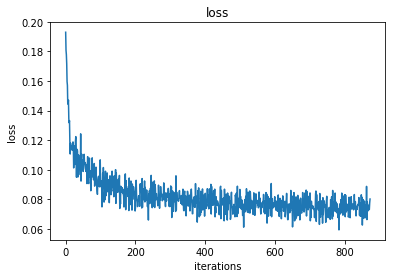

Epoch: 33/200... Training loss: 0.0759
Epoch: 33/200... Training loss: 0.0763
Epoch: 33/200... Training loss: 0.0766
Epoch: 33/200... Training loss: 0.0712
Epoch: 33/200... Training loss: 0.0741
Epoch: 33/200... Training loss: 0.0749
Epoch: 33/200... Training loss: 0.0771
Epoch: 33/200... Training loss: 0.0697
Epoch: 33/200... Training loss: 0.0797
Epoch: 33/200... Training loss: 0.0810
Epoch: 33/200... Training loss: 0.0724
Epoch: 33/200... Training loss: 0.0682
Epoch: 33/200... Training loss: 0.0660
Epoch: 33/200... Training loss: 0.0775
Epoch: 33/200... Training loss: 0.0799
Epoch: 33/200... Training loss: 0.0704
Epoch: 33/200... Training loss: 0.0725
Epoch: 33/200... Training loss: 0.0771
Epoch: 33/200... Training loss: 0.0656
Epoch: 33/200... Training loss: 0.0731
Epoch: 33/200... Training loss: 0.0740
Epoch: 33/200... Training loss: 0.0733
Epoch: 33/200... Training loss: 0.0794
Epoch: 33/200... Training loss: 0.0782
Epoch: 33/200... Training loss: 0.0703
Epoch: 33/200... Training

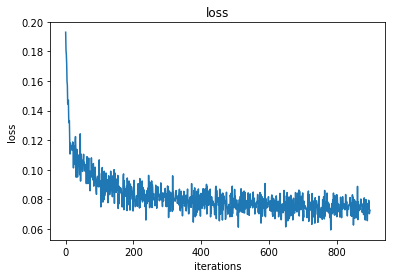

Epoch: 34/200... Training loss: 0.0768
Epoch: 34/200... Training loss: 0.0760
Epoch: 34/200... Training loss: 0.0665
Epoch: 34/200... Training loss: 0.0695
Epoch: 34/200... Training loss: 0.0748
Epoch: 34/200... Training loss: 0.0772
Epoch: 34/200... Training loss: 0.0808
Epoch: 34/200... Training loss: 0.0763
Epoch: 34/200... Training loss: 0.0733
Epoch: 34/200... Training loss: 0.0650
Epoch: 34/200... Training loss: 0.0643
Epoch: 34/200... Training loss: 0.0743
Epoch: 34/200... Training loss: 0.0750
Epoch: 34/200... Training loss: 0.0750
Epoch: 34/200... Training loss: 0.0745
Epoch: 34/200... Training loss: 0.0690
Epoch: 34/200... Training loss: 0.0749
Epoch: 34/200... Training loss: 0.0701
Epoch: 34/200... Training loss: 0.0838
Epoch: 34/200... Training loss: 0.0725
Epoch: 34/200... Training loss: 0.0769
Epoch: 34/200... Training loss: 0.0723
Epoch: 34/200... Training loss: 0.0724
Epoch: 34/200... Training loss: 0.0602
Epoch: 34/200... Training loss: 0.0680
Epoch: 34/200... Training

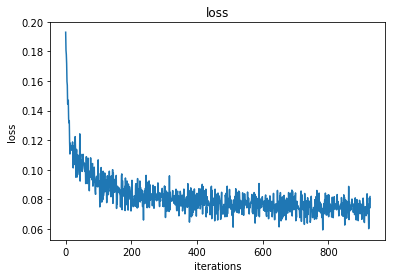

Epoch: 35/200... Training loss: 0.0748
Epoch: 35/200... Training loss: 0.0640
Epoch: 35/200... Training loss: 0.0670
Epoch: 35/200... Training loss: 0.0697
Epoch: 35/200... Training loss: 0.0660
Epoch: 35/200... Training loss: 0.0794
Epoch: 35/200... Training loss: 0.0660
Epoch: 35/200... Training loss: 0.0684
Epoch: 35/200... Training loss: 0.0702
Epoch: 35/200... Training loss: 0.0734
Epoch: 35/200... Training loss: 0.0805
Epoch: 35/200... Training loss: 0.0670
Epoch: 35/200... Training loss: 0.0756
Epoch: 35/200... Training loss: 0.0767
Epoch: 35/200... Training loss: 0.0781
Epoch: 35/200... Training loss: 0.0743
Epoch: 35/200... Training loss: 0.0645
Epoch: 35/200... Training loss: 0.0748
Epoch: 35/200... Training loss: 0.0784
Epoch: 35/200... Training loss: 0.0749
Epoch: 35/200... Training loss: 0.0722
Epoch: 35/200... Training loss: 0.0687
Epoch: 35/200... Training loss: 0.0724
Epoch: 35/200... Training loss: 0.0710
Epoch: 35/200... Training loss: 0.0818
Epoch: 35/200... Training

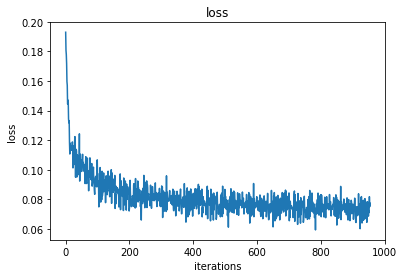

Epoch: 36/200... Training loss: 0.0781
Epoch: 36/200... Training loss: 0.0702
Epoch: 36/200... Training loss: 0.0712
Epoch: 36/200... Training loss: 0.0826
Epoch: 36/200... Training loss: 0.0727
Epoch: 36/200... Training loss: 0.0757
Epoch: 36/200... Training loss: 0.0766
Epoch: 36/200... Training loss: 0.0850
Epoch: 36/200... Training loss: 0.0670
Epoch: 36/200... Training loss: 0.0833
Epoch: 36/200... Training loss: 0.0742
Epoch: 36/200... Training loss: 0.0736
Epoch: 36/200... Training loss: 0.0800
Epoch: 36/200... Training loss: 0.0719
Epoch: 36/200... Training loss: 0.0777
Epoch: 36/200... Training loss: 0.0812
Epoch: 36/200... Training loss: 0.0726
Epoch: 36/200... Training loss: 0.0752
Epoch: 36/200... Training loss: 0.0824
Epoch: 36/200... Training loss: 0.0638
Epoch: 36/200... Training loss: 0.0706
Epoch: 36/200... Training loss: 0.0666
Epoch: 36/200... Training loss: 0.0775
Epoch: 36/200... Training loss: 0.0739
Epoch: 36/200... Training loss: 0.0731
Epoch: 36/200... Training

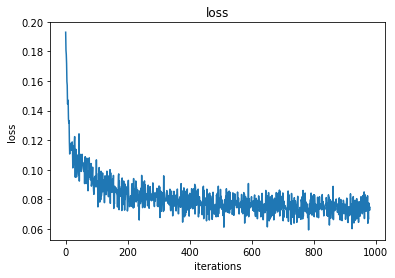

Epoch: 37/200... Training loss: 0.0718
Epoch: 37/200... Training loss: 0.0725
Epoch: 37/200... Training loss: 0.0704
Epoch: 37/200... Training loss: 0.0703
Epoch: 37/200... Training loss: 0.0667
Epoch: 37/200... Training loss: 0.0719
Epoch: 37/200... Training loss: 0.0730
Epoch: 37/200... Training loss: 0.0822
Epoch: 37/200... Training loss: 0.0842
Epoch: 37/200... Training loss: 0.0640
Epoch: 37/200... Training loss: 0.0820
Epoch: 37/200... Training loss: 0.0734
Epoch: 37/200... Training loss: 0.0742
Epoch: 37/200... Training loss: 0.0743
Epoch: 37/200... Training loss: 0.0753
Epoch: 37/200... Training loss: 0.0709
Epoch: 37/200... Training loss: 0.0722
Epoch: 37/200... Training loss: 0.0779
Epoch: 37/200... Training loss: 0.0617
Epoch: 37/200... Training loss: 0.0821
Epoch: 37/200... Training loss: 0.0758
Epoch: 37/200... Training loss: 0.0659
Epoch: 37/200... Training loss: 0.0743
Epoch: 37/200... Training loss: 0.0684
Epoch: 37/200... Training loss: 0.0777
Epoch: 37/200... Training

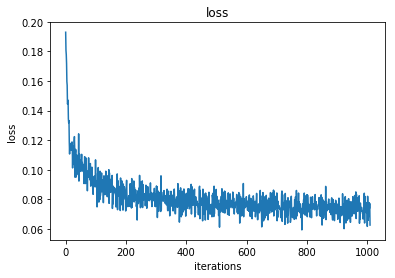

Epoch: 38/200... Training loss: 0.0802
Epoch: 38/200... Training loss: 0.0677
Epoch: 38/200... Training loss: 0.0711
Epoch: 38/200... Training loss: 0.0780
Epoch: 38/200... Training loss: 0.0767
Epoch: 38/200... Training loss: 0.0739
Epoch: 38/200... Training loss: 0.0729
Epoch: 38/200... Training loss: 0.0741
Epoch: 38/200... Training loss: 0.0639
Epoch: 38/200... Training loss: 0.0650
Epoch: 38/200... Training loss: 0.0769
Epoch: 38/200... Training loss: 0.0806
Epoch: 38/200... Training loss: 0.0721
Epoch: 38/200... Training loss: 0.0713
Epoch: 38/200... Training loss: 0.0696
Epoch: 38/200... Training loss: 0.0669
Epoch: 38/200... Training loss: 0.0706
Epoch: 38/200... Training loss: 0.0710
Epoch: 38/200... Training loss: 0.0736
Epoch: 38/200... Training loss: 0.0723
Epoch: 38/200... Training loss: 0.0711
Epoch: 38/200... Training loss: 0.0653
Epoch: 38/200... Training loss: 0.0784
Epoch: 38/200... Training loss: 0.0772
Epoch: 38/200... Training loss: 0.0757
Epoch: 38/200... Training

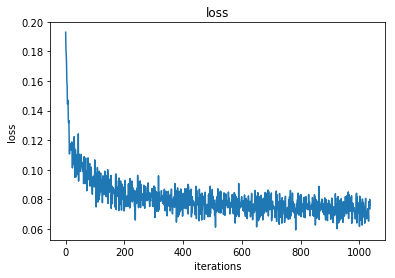

Epoch: 39/200... Training loss: 0.0656
Epoch: 39/200... Training loss: 0.0853
Epoch: 39/200... Training loss: 0.0668
Epoch: 39/200... Training loss: 0.0772
Epoch: 39/200... Training loss: 0.0728
Epoch: 39/200... Training loss: 0.0704
Epoch: 39/200... Training loss: 0.0759
Epoch: 39/200... Training loss: 0.0738
Epoch: 39/200... Training loss: 0.0828
Epoch: 39/200... Training loss: 0.0697
Epoch: 39/200... Training loss: 0.0766
Epoch: 39/200... Training loss: 0.0705
Epoch: 39/200... Training loss: 0.0703
Epoch: 39/200... Training loss: 0.0694
Epoch: 39/200... Training loss: 0.0762
Epoch: 39/200... Training loss: 0.0726
Epoch: 39/200... Training loss: 0.0664
Epoch: 39/200... Training loss: 0.0680
Epoch: 39/200... Training loss: 0.0695
Epoch: 39/200... Training loss: 0.0579
Epoch: 39/200... Training loss: 0.0731
Epoch: 39/200... Training loss: 0.0701
Epoch: 39/200... Training loss: 0.0754
Epoch: 39/200... Training loss: 0.0684
Epoch: 39/200... Training loss: 0.0758
Epoch: 39/200... Training

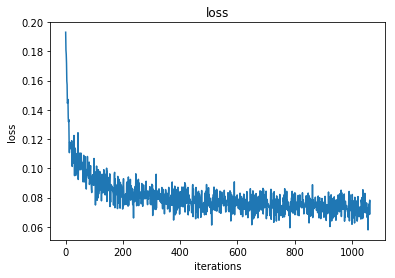

Epoch: 40/200... Training loss: 0.0825
Epoch: 40/200... Training loss: 0.0751
Epoch: 40/200... Training loss: 0.0730
Epoch: 40/200... Training loss: 0.0684
Epoch: 40/200... Training loss: 0.0812
Epoch: 40/200... Training loss: 0.0734
Epoch: 40/200... Training loss: 0.0736
Epoch: 40/200... Training loss: 0.0684
Epoch: 40/200... Training loss: 0.0794
Epoch: 40/200... Training loss: 0.0823
Epoch: 40/200... Training loss: 0.0668
Epoch: 40/200... Training loss: 0.0817
Epoch: 40/200... Training loss: 0.0766
Epoch: 40/200... Training loss: 0.0700
Epoch: 40/200... Training loss: 0.0745
Epoch: 40/200... Training loss: 0.0755
Epoch: 40/200... Training loss: 0.0729
Epoch: 40/200... Training loss: 0.0714
Epoch: 40/200... Training loss: 0.0736
Epoch: 40/200... Training loss: 0.0671
Epoch: 40/200... Training loss: 0.0680
Epoch: 40/200... Training loss: 0.0801
Epoch: 40/200... Training loss: 0.0737
Epoch: 40/200... Training loss: 0.0727
Epoch: 40/200... Training loss: 0.0661
Epoch: 40/200... Training

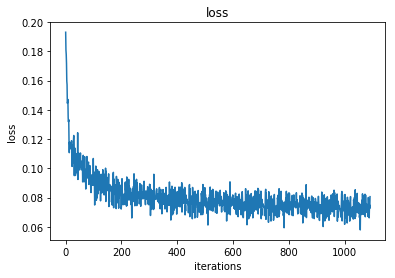

Epoch: 41/200... Training loss: 0.0751
Epoch: 41/200... Training loss: 0.0758
Epoch: 41/200... Training loss: 0.0733
Epoch: 41/200... Training loss: 0.0754
Epoch: 41/200... Training loss: 0.0722
Epoch: 41/200... Training loss: 0.0754
Epoch: 41/200... Training loss: 0.0714
Epoch: 41/200... Training loss: 0.0728
Epoch: 41/200... Training loss: 0.0817
Epoch: 41/200... Training loss: 0.0729
Epoch: 41/200... Training loss: 0.0737
Epoch: 41/200... Training loss: 0.0777
Epoch: 41/200... Training loss: 0.0717
Epoch: 41/200... Training loss: 0.0682
Epoch: 41/200... Training loss: 0.0735
Epoch: 41/200... Training loss: 0.0737
Epoch: 41/200... Training loss: 0.0727
Epoch: 41/200... Training loss: 0.0742
Epoch: 41/200... Training loss: 0.0751
Epoch: 41/200... Training loss: 0.0753
Epoch: 41/200... Training loss: 0.0750
Epoch: 41/200... Training loss: 0.0800
Epoch: 41/200... Training loss: 0.0772
Epoch: 41/200... Training loss: 0.0684
Epoch: 41/200... Training loss: 0.0760
Epoch: 41/200... Training

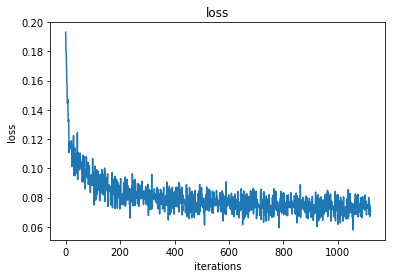

Epoch: 42/200... Training loss: 0.0678
Epoch: 42/200... Training loss: 0.0815
Epoch: 42/200... Training loss: 0.0734
Epoch: 42/200... Training loss: 0.0801
Epoch: 42/200... Training loss: 0.0618
Epoch: 42/200... Training loss: 0.0722
Epoch: 42/200... Training loss: 0.0787
Epoch: 42/200... Training loss: 0.0777
Epoch: 42/200... Training loss: 0.0666
Epoch: 42/200... Training loss: 0.0698
Epoch: 42/200... Training loss: 0.0769
Epoch: 42/200... Training loss: 0.0708
Epoch: 42/200... Training loss: 0.0726
Epoch: 42/200... Training loss: 0.0714
Epoch: 42/200... Training loss: 0.0752
Epoch: 42/200... Training loss: 0.0666
Epoch: 42/200... Training loss: 0.0881
Epoch: 42/200... Training loss: 0.0650
Epoch: 42/200... Training loss: 0.0781
Epoch: 42/200... Training loss: 0.0732
Epoch: 42/200... Training loss: 0.0740
Epoch: 42/200... Training loss: 0.0699
Epoch: 42/200... Training loss: 0.0756
Epoch: 42/200... Training loss: 0.0726
Epoch: 42/200... Training loss: 0.0718
Epoch: 42/200... Training

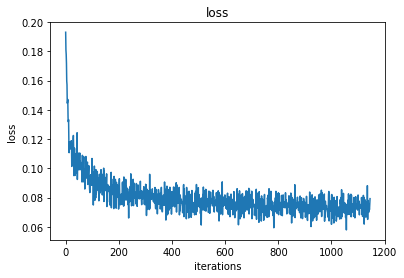

Epoch: 43/200... Training loss: 0.0745
Epoch: 43/200... Training loss: 0.0751
Epoch: 43/200... Training loss: 0.0762
Epoch: 43/200... Training loss: 0.0707
Epoch: 43/200... Training loss: 0.0732
Epoch: 43/200... Training loss: 0.0736
Epoch: 43/200... Training loss: 0.0761
Epoch: 43/200... Training loss: 0.0684
Epoch: 43/200... Training loss: 0.0789
Epoch: 43/200... Training loss: 0.0797
Epoch: 43/200... Training loss: 0.0717
Epoch: 43/200... Training loss: 0.0669
Epoch: 43/200... Training loss: 0.0649
Epoch: 43/200... Training loss: 0.0758
Epoch: 43/200... Training loss: 0.0784
Epoch: 43/200... Training loss: 0.0701
Epoch: 43/200... Training loss: 0.0713
Epoch: 43/200... Training loss: 0.0768
Epoch: 43/200... Training loss: 0.0644
Epoch: 43/200... Training loss: 0.0720
Epoch: 43/200... Training loss: 0.0728
Epoch: 43/200... Training loss: 0.0722
Epoch: 43/200... Training loss: 0.0780
Epoch: 43/200... Training loss: 0.0773
Epoch: 43/200... Training loss: 0.0694
Epoch: 43/200... Training

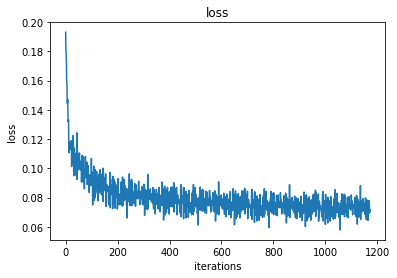

Epoch: 44/200... Training loss: 0.0760
Epoch: 44/200... Training loss: 0.0745
Epoch: 44/200... Training loss: 0.0657
Epoch: 44/200... Training loss: 0.0686
Epoch: 44/200... Training loss: 0.0738
Epoch: 44/200... Training loss: 0.0762
Epoch: 44/200... Training loss: 0.0798
Epoch: 44/200... Training loss: 0.0744
Epoch: 44/200... Training loss: 0.0717
Epoch: 44/200... Training loss: 0.0640
Epoch: 44/200... Training loss: 0.0632
Epoch: 44/200... Training loss: 0.0739
Epoch: 44/200... Training loss: 0.0736
Epoch: 44/200... Training loss: 0.0728
Epoch: 44/200... Training loss: 0.0731
Epoch: 44/200... Training loss: 0.0681
Epoch: 44/200... Training loss: 0.0744
Epoch: 44/200... Training loss: 0.0689
Epoch: 44/200... Training loss: 0.0829
Epoch: 44/200... Training loss: 0.0715
Epoch: 44/200... Training loss: 0.0744
Epoch: 44/200... Training loss: 0.0715
Epoch: 44/200... Training loss: 0.0712
Epoch: 44/200... Training loss: 0.0593
Epoch: 44/200... Training loss: 0.0665
Epoch: 44/200... Training

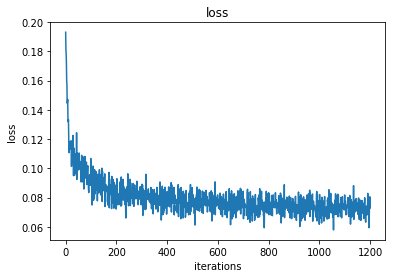

Epoch: 45/200... Training loss: 0.0734
Epoch: 45/200... Training loss: 0.0632
Epoch: 45/200... Training loss: 0.0660
Epoch: 45/200... Training loss: 0.0688
Epoch: 45/200... Training loss: 0.0647
Epoch: 45/200... Training loss: 0.0791
Epoch: 45/200... Training loss: 0.0650
Epoch: 45/200... Training loss: 0.0674
Epoch: 45/200... Training loss: 0.0684
Epoch: 45/200... Training loss: 0.0719
Epoch: 45/200... Training loss: 0.0803
Epoch: 45/200... Training loss: 0.0659
Epoch: 45/200... Training loss: 0.0745
Epoch: 45/200... Training loss: 0.0754
Epoch: 45/200... Training loss: 0.0772
Epoch: 45/200... Training loss: 0.0729
Epoch: 45/200... Training loss: 0.0634
Epoch: 45/200... Training loss: 0.0740
Epoch: 45/200... Training loss: 0.0773
Epoch: 45/200... Training loss: 0.0729
Epoch: 45/200... Training loss: 0.0710
Epoch: 45/200... Training loss: 0.0670
Epoch: 45/200... Training loss: 0.0712
Epoch: 45/200... Training loss: 0.0700
Epoch: 45/200... Training loss: 0.0805
Epoch: 45/200... Training

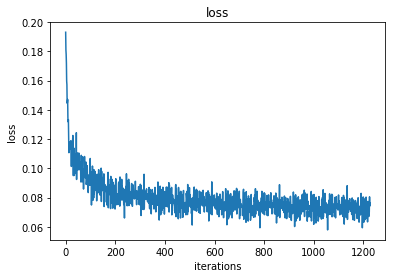

Epoch: 46/200... Training loss: 0.0768
Epoch: 46/200... Training loss: 0.0688
Epoch: 46/200... Training loss: 0.0706
Epoch: 46/200... Training loss: 0.0822
Epoch: 46/200... Training loss: 0.0719
Epoch: 46/200... Training loss: 0.0747
Epoch: 46/200... Training loss: 0.0759
Epoch: 46/200... Training loss: 0.0832
Epoch: 46/200... Training loss: 0.0664
Epoch: 46/200... Training loss: 0.0825
Epoch: 46/200... Training loss: 0.0731
Epoch: 46/200... Training loss: 0.0725
Epoch: 46/200... Training loss: 0.0790
Epoch: 46/200... Training loss: 0.0708
Epoch: 46/200... Training loss: 0.0768
Epoch: 46/200... Training loss: 0.0801
Epoch: 46/200... Training loss: 0.0720
Epoch: 46/200... Training loss: 0.0734
Epoch: 46/200... Training loss: 0.0815
Epoch: 46/200... Training loss: 0.0634
Epoch: 46/200... Training loss: 0.0692
Epoch: 46/200... Training loss: 0.0663
Epoch: 46/200... Training loss: 0.0771
Epoch: 46/200... Training loss: 0.0729
Epoch: 46/200... Training loss: 0.0721
Epoch: 46/200... Training

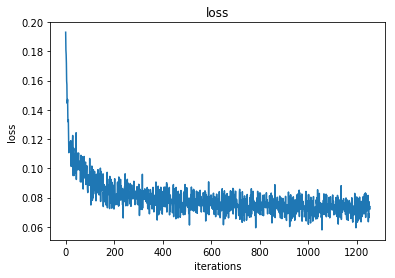

Epoch: 47/200... Training loss: 0.0715
Epoch: 47/200... Training loss: 0.0711
Epoch: 47/200... Training loss: 0.0698
Epoch: 47/200... Training loss: 0.0697
Epoch: 47/200... Training loss: 0.0656
Epoch: 47/200... Training loss: 0.0705
Epoch: 47/200... Training loss: 0.0723
Epoch: 47/200... Training loss: 0.0818
Epoch: 47/200... Training loss: 0.0833
Epoch: 47/200... Training loss: 0.0638
Epoch: 47/200... Training loss: 0.0808
Epoch: 47/200... Training loss: 0.0723
Epoch: 47/200... Training loss: 0.0731
Epoch: 47/200... Training loss: 0.0733
Epoch: 47/200... Training loss: 0.0742
Epoch: 47/200... Training loss: 0.0700
Epoch: 47/200... Training loss: 0.0713
Epoch: 47/200... Training loss: 0.0771
Epoch: 47/200... Training loss: 0.0612
Epoch: 47/200... Training loss: 0.0813
Epoch: 47/200... Training loss: 0.0746
Epoch: 47/200... Training loss: 0.0656
Epoch: 47/200... Training loss: 0.0731
Epoch: 47/200... Training loss: 0.0674
Epoch: 47/200... Training loss: 0.0770
Epoch: 47/200... Training

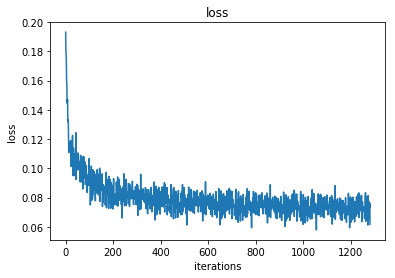

Epoch: 48/200... Training loss: 0.0799
Epoch: 48/200... Training loss: 0.0673
Epoch: 48/200... Training loss: 0.0706
Epoch: 48/200... Training loss: 0.0772
Epoch: 48/200... Training loss: 0.0752
Epoch: 48/200... Training loss: 0.0731
Epoch: 48/200... Training loss: 0.0719
Epoch: 48/200... Training loss: 0.0730
Epoch: 48/200... Training loss: 0.0635
Epoch: 48/200... Training loss: 0.0640
Epoch: 48/200... Training loss: 0.0757
Epoch: 48/200... Training loss: 0.0790
Epoch: 48/200... Training loss: 0.0709
Epoch: 48/200... Training loss: 0.0706
Epoch: 48/200... Training loss: 0.0690
Epoch: 48/200... Training loss: 0.0665
Epoch: 48/200... Training loss: 0.0695
Epoch: 48/200... Training loss: 0.0701
Epoch: 48/200... Training loss: 0.0725
Epoch: 48/200... Training loss: 0.0715
Epoch: 48/200... Training loss: 0.0697
Epoch: 48/200... Training loss: 0.0645
Epoch: 48/200... Training loss: 0.0776
Epoch: 48/200... Training loss: 0.0769
Epoch: 48/200... Training loss: 0.0747
Epoch: 48/200... Training

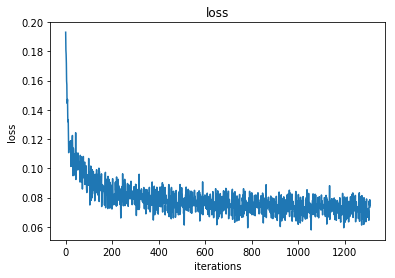

Epoch: 49/200... Training loss: 0.0646
Epoch: 49/200... Training loss: 0.0845
Epoch: 49/200... Training loss: 0.0664
Epoch: 49/200... Training loss: 0.0763
Epoch: 49/200... Training loss: 0.0720
Epoch: 49/200... Training loss: 0.0699
Epoch: 49/200... Training loss: 0.0756
Epoch: 49/200... Training loss: 0.0731
Epoch: 49/200... Training loss: 0.0808
Epoch: 49/200... Training loss: 0.0683
Epoch: 49/200... Training loss: 0.0764
Epoch: 49/200... Training loss: 0.0701
Epoch: 49/200... Training loss: 0.0700
Epoch: 49/200... Training loss: 0.0692
Epoch: 49/200... Training loss: 0.0753
Epoch: 49/200... Training loss: 0.0722
Epoch: 49/200... Training loss: 0.0658
Epoch: 49/200... Training loss: 0.0675
Epoch: 49/200... Training loss: 0.0691
Epoch: 49/200... Training loss: 0.0569
Epoch: 49/200... Training loss: 0.0726
Epoch: 49/200... Training loss: 0.0697
Epoch: 49/200... Training loss: 0.0747
Epoch: 49/200... Training loss: 0.0672
Epoch: 49/200... Training loss: 0.0751
Epoch: 49/200... Training

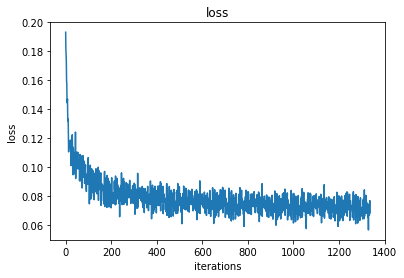

Epoch: 50/200... Training loss: 0.0814
Epoch: 50/200... Training loss: 0.0740
Epoch: 50/200... Training loss: 0.0714
Epoch: 50/200... Training loss: 0.0676
Epoch: 50/200... Training loss: 0.0807
Epoch: 50/200... Training loss: 0.0721
Epoch: 50/200... Training loss: 0.0728
Epoch: 50/200... Training loss: 0.0675
Epoch: 50/200... Training loss: 0.0786
Epoch: 50/200... Training loss: 0.0806
Epoch: 50/200... Training loss: 0.0659
Epoch: 50/200... Training loss: 0.0803
Epoch: 50/200... Training loss: 0.0754
Epoch: 50/200... Training loss: 0.0694
Epoch: 50/200... Training loss: 0.0734
Epoch: 50/200... Training loss: 0.0744
Epoch: 50/200... Training loss: 0.0716
Epoch: 50/200... Training loss: 0.0709
Epoch: 50/200... Training loss: 0.0722
Epoch: 50/200... Training loss: 0.0658
Epoch: 50/200... Training loss: 0.0675
Epoch: 50/200... Training loss: 0.0792
Epoch: 50/200... Training loss: 0.0728
Epoch: 50/200... Training loss: 0.0717
Epoch: 50/200... Training loss: 0.0653
Epoch: 50/200... Training

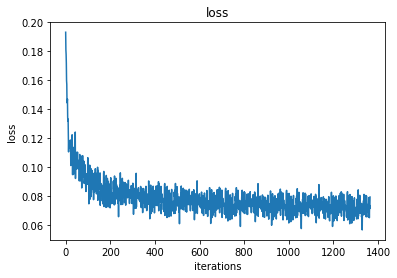

Epoch: 51/200... Training loss: 0.0744
Epoch: 51/200... Training loss: 0.0752
Epoch: 51/200... Training loss: 0.0728
Epoch: 51/200... Training loss: 0.0747
Epoch: 51/200... Training loss: 0.0718
Epoch: 51/200... Training loss: 0.0751
Epoch: 51/200... Training loss: 0.0700
Epoch: 51/200... Training loss: 0.0719
Epoch: 51/200... Training loss: 0.0806
Epoch: 51/200... Training loss: 0.0720
Epoch: 51/200... Training loss: 0.0727
Epoch: 51/200... Training loss: 0.0765
Epoch: 51/200... Training loss: 0.0705
Epoch: 51/200... Training loss: 0.0669
Epoch: 51/200... Training loss: 0.0725
Epoch: 51/200... Training loss: 0.0719
Epoch: 51/200... Training loss: 0.0717
Epoch: 51/200... Training loss: 0.0735
Epoch: 51/200... Training loss: 0.0738
Epoch: 51/200... Training loss: 0.0741
Epoch: 51/200... Training loss: 0.0733
Epoch: 51/200... Training loss: 0.0793
Epoch: 51/200... Training loss: 0.0767
Epoch: 51/200... Training loss: 0.0677
Epoch: 51/200... Training loss: 0.0758
Epoch: 51/200... Training

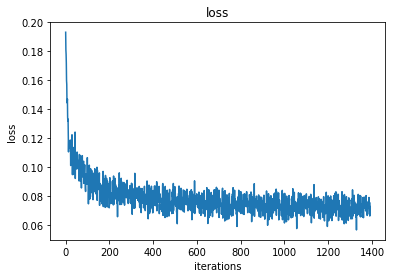

Epoch: 52/200... Training loss: 0.0666
Epoch: 52/200... Training loss: 0.0802
Epoch: 52/200... Training loss: 0.0724
Epoch: 52/200... Training loss: 0.0786
Epoch: 52/200... Training loss: 0.0616
Epoch: 52/200... Training loss: 0.0713
Epoch: 52/200... Training loss: 0.0777
Epoch: 52/200... Training loss: 0.0767
Epoch: 52/200... Training loss: 0.0658
Epoch: 52/200... Training loss: 0.0687
Epoch: 52/200... Training loss: 0.0761
Epoch: 52/200... Training loss: 0.0699
Epoch: 52/200... Training loss: 0.0722
Epoch: 52/200... Training loss: 0.0711
Epoch: 52/200... Training loss: 0.0743
Epoch: 52/200... Training loss: 0.0657
Epoch: 52/200... Training loss: 0.0873
Epoch: 52/200... Training loss: 0.0640
Epoch: 52/200... Training loss: 0.0771
Epoch: 52/200... Training loss: 0.0731
Epoch: 52/200... Training loss: 0.0730
Epoch: 52/200... Training loss: 0.0688
Epoch: 52/200... Training loss: 0.0754
Epoch: 52/200... Training loss: 0.0723
Epoch: 52/200... Training loss: 0.0710
Epoch: 52/200... Training

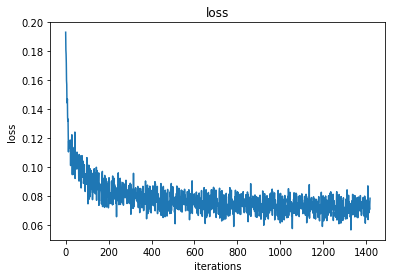

Epoch: 53/200... Training loss: 0.0736
Epoch: 53/200... Training loss: 0.0742
Epoch: 53/200... Training loss: 0.0745
Epoch: 53/200... Training loss: 0.0703
Epoch: 53/200... Training loss: 0.0723
Epoch: 53/200... Training loss: 0.0737
Epoch: 53/200... Training loss: 0.0761
Epoch: 53/200... Training loss: 0.0676
Epoch: 53/200... Training loss: 0.0784
Epoch: 53/200... Training loss: 0.0789
Epoch: 53/200... Training loss: 0.0710
Epoch: 53/200... Training loss: 0.0659
Epoch: 53/200... Training loss: 0.0638
Epoch: 53/200... Training loss: 0.0755
Epoch: 53/200... Training loss: 0.0778
Epoch: 53/200... Training loss: 0.0695
Epoch: 53/200... Training loss: 0.0707
Epoch: 53/200... Training loss: 0.0763
Epoch: 53/200... Training loss: 0.0637
Epoch: 53/200... Training loss: 0.0710
Epoch: 53/200... Training loss: 0.0715
Epoch: 53/200... Training loss: 0.0718
Epoch: 53/200... Training loss: 0.0773
Epoch: 53/200... Training loss: 0.0761
Epoch: 53/200... Training loss: 0.0690
Epoch: 53/200... Training

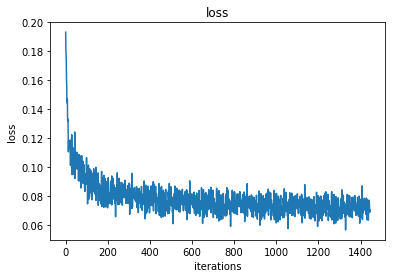

Epoch: 54/200... Training loss: 0.0750
Epoch: 54/200... Training loss: 0.0736
Epoch: 54/200... Training loss: 0.0645
Epoch: 54/200... Training loss: 0.0675
Epoch: 54/200... Training loss: 0.0732
Epoch: 54/200... Training loss: 0.0755
Epoch: 54/200... Training loss: 0.0794
Epoch: 54/200... Training loss: 0.0739
Epoch: 54/200... Training loss: 0.0716
Epoch: 54/200... Training loss: 0.0631
Epoch: 54/200... Training loss: 0.0623
Epoch: 54/200... Training loss: 0.0722
Epoch: 54/200... Training loss: 0.0729
Epoch: 54/200... Training loss: 0.0720
Epoch: 54/200... Training loss: 0.0722
Epoch: 54/200... Training loss: 0.0676
Epoch: 54/200... Training loss: 0.0734
Epoch: 54/200... Training loss: 0.0683
Epoch: 54/200... Training loss: 0.0818
Epoch: 54/200... Training loss: 0.0714
Epoch: 54/200... Training loss: 0.0743
Epoch: 54/200... Training loss: 0.0706
Epoch: 54/200... Training loss: 0.0705
Epoch: 54/200... Training loss: 0.0585
Epoch: 54/200... Training loss: 0.0663
Epoch: 54/200... Training

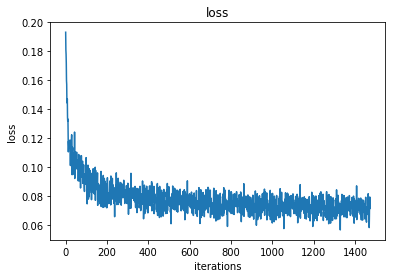

Epoch: 55/200... Training loss: 0.0723
Epoch: 55/200... Training loss: 0.0627
Epoch: 55/200... Training loss: 0.0655
Epoch: 55/200... Training loss: 0.0685
Epoch: 55/200... Training loss: 0.0641
Epoch: 55/200... Training loss: 0.0782
Epoch: 55/200... Training loss: 0.0644
Epoch: 55/200... Training loss: 0.0668
Epoch: 55/200... Training loss: 0.0680
Epoch: 55/200... Training loss: 0.0721
Epoch: 55/200... Training loss: 0.0791
Epoch: 55/200... Training loss: 0.0656
Epoch: 55/200... Training loss: 0.0739
Epoch: 55/200... Training loss: 0.0751
Epoch: 55/200... Training loss: 0.0766
Epoch: 55/200... Training loss: 0.0722
Epoch: 55/200... Training loss: 0.0630
Epoch: 55/200... Training loss: 0.0735
Epoch: 55/200... Training loss: 0.0768
Epoch: 55/200... Training loss: 0.0720
Epoch: 55/200... Training loss: 0.0701
Epoch: 55/200... Training loss: 0.0659
Epoch: 55/200... Training loss: 0.0707
Epoch: 55/200... Training loss: 0.0693
Epoch: 55/200... Training loss: 0.0796
Epoch: 55/200... Training

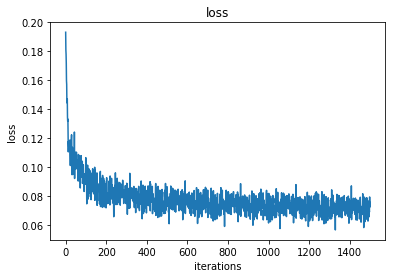

Epoch: 56/200... Training loss: 0.0758
Epoch: 56/200... Training loss: 0.0681
Epoch: 56/200... Training loss: 0.0692
Epoch: 56/200... Training loss: 0.0816
Epoch: 56/200... Training loss: 0.0710
Epoch: 56/200... Training loss: 0.0741
Epoch: 56/200... Training loss: 0.0746
Epoch: 56/200... Training loss: 0.0824
Epoch: 56/200... Training loss: 0.0654
Epoch: 56/200... Training loss: 0.0814
Epoch: 56/200... Training loss: 0.0730
Epoch: 56/200... Training loss: 0.0716
Epoch: 56/200... Training loss: 0.0781
Epoch: 56/200... Training loss: 0.0702
Epoch: 56/200... Training loss: 0.0755
Epoch: 56/200... Training loss: 0.0799
Epoch: 56/200... Training loss: 0.0718
Epoch: 56/200... Training loss: 0.0724
Epoch: 56/200... Training loss: 0.0804
Epoch: 56/200... Training loss: 0.0625
Epoch: 56/200... Training loss: 0.0687
Epoch: 56/200... Training loss: 0.0655
Epoch: 56/200... Training loss: 0.0761
Epoch: 56/200... Training loss: 0.0722
Epoch: 56/200... Training loss: 0.0715
Epoch: 56/200... Training

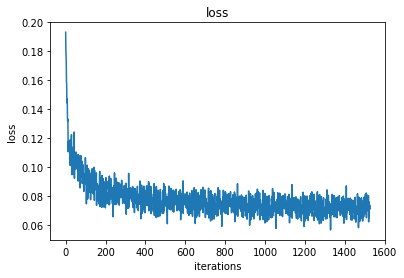

Epoch: 57/200... Training loss: 0.0703
Epoch: 57/200... Training loss: 0.0700
Epoch: 57/200... Training loss: 0.0691
Epoch: 57/200... Training loss: 0.0688
Epoch: 57/200... Training loss: 0.0646
Epoch: 57/200... Training loss: 0.0698
Epoch: 57/200... Training loss: 0.0714
Epoch: 57/200... Training loss: 0.0812
Epoch: 57/200... Training loss: 0.0828
Epoch: 57/200... Training loss: 0.0629
Epoch: 57/200... Training loss: 0.0804
Epoch: 57/200... Training loss: 0.0720
Epoch: 57/200... Training loss: 0.0725
Epoch: 57/200... Training loss: 0.0730
Epoch: 57/200... Training loss: 0.0732
Epoch: 57/200... Training loss: 0.0696
Epoch: 57/200... Training loss: 0.0708
Epoch: 57/200... Training loss: 0.0763
Epoch: 57/200... Training loss: 0.0606
Epoch: 57/200... Training loss: 0.0802
Epoch: 57/200... Training loss: 0.0739
Epoch: 57/200... Training loss: 0.0644
Epoch: 57/200... Training loss: 0.0728
Epoch: 57/200... Training loss: 0.0665
Epoch: 57/200... Training loss: 0.0766
Epoch: 57/200... Training

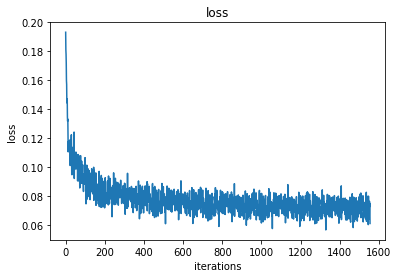

Epoch: 58/200... Training loss: 0.0784
Epoch: 58/200... Training loss: 0.0661
Epoch: 58/200... Training loss: 0.0697
Epoch: 58/200... Training loss: 0.0763
Epoch: 58/200... Training loss: 0.0746
Epoch: 58/200... Training loss: 0.0718
Epoch: 58/200... Training loss: 0.0716
Epoch: 58/200... Training loss: 0.0719
Epoch: 58/200... Training loss: 0.0628
Epoch: 58/200... Training loss: 0.0629
Epoch: 58/200... Training loss: 0.0741
Epoch: 58/200... Training loss: 0.0789
Epoch: 58/200... Training loss: 0.0705
Epoch: 58/200... Training loss: 0.0697
Epoch: 58/200... Training loss: 0.0685
Epoch: 58/200... Training loss: 0.0658
Epoch: 58/200... Training loss: 0.0690
Epoch: 58/200... Training loss: 0.0692
Epoch: 58/200... Training loss: 0.0717
Epoch: 58/200... Training loss: 0.0707
Epoch: 58/200... Training loss: 0.0687
Epoch: 58/200... Training loss: 0.0636
Epoch: 58/200... Training loss: 0.0773
Epoch: 58/200... Training loss: 0.0757
Epoch: 58/200... Training loss: 0.0738
Epoch: 58/200... Training

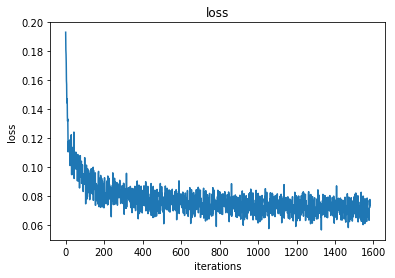

Epoch: 59/200... Training loss: 0.0640
Epoch: 59/200... Training loss: 0.0835
Epoch: 59/200... Training loss: 0.0658
Epoch: 59/200... Training loss: 0.0762
Epoch: 59/200... Training loss: 0.0715
Epoch: 59/200... Training loss: 0.0693
Epoch: 59/200... Training loss: 0.0749
Epoch: 59/200... Training loss: 0.0724
Epoch: 59/200... Training loss: 0.0802
Epoch: 59/200... Training loss: 0.0670
Epoch: 59/200... Training loss: 0.0755
Epoch: 59/200... Training loss: 0.0691
Epoch: 59/200... Training loss: 0.0699
Epoch: 59/200... Training loss: 0.0681
Epoch: 59/200... Training loss: 0.0742
Epoch: 59/200... Training loss: 0.0711
Epoch: 59/200... Training loss: 0.0657
Epoch: 59/200... Training loss: 0.0667
Epoch: 59/200... Training loss: 0.0682
Epoch: 59/200... Training loss: 0.0560
Epoch: 59/200... Training loss: 0.0716
Epoch: 59/200... Training loss: 0.0692
Epoch: 59/200... Training loss: 0.0748
Epoch: 59/200... Training loss: 0.0670
Epoch: 59/200... Training loss: 0.0747
Epoch: 59/200... Training

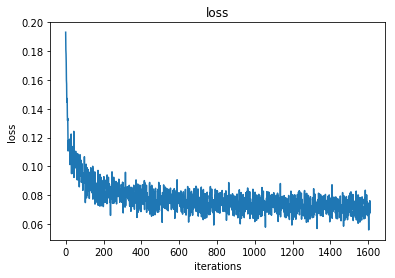

Epoch: 60/200... Training loss: 0.0808
Epoch: 60/200... Training loss: 0.0732
Epoch: 60/200... Training loss: 0.0712
Epoch: 60/200... Training loss: 0.0669
Epoch: 60/200... Training loss: 0.0799
Epoch: 60/200... Training loss: 0.0714
Epoch: 60/200... Training loss: 0.0722
Epoch: 60/200... Training loss: 0.0670
Epoch: 60/200... Training loss: 0.0779
Epoch: 60/200... Training loss: 0.0798
Epoch: 60/200... Training loss: 0.0650
Epoch: 60/200... Training loss: 0.0799
Epoch: 60/200... Training loss: 0.0746
Epoch: 60/200... Training loss: 0.0687
Epoch: 60/200... Training loss: 0.0728
Epoch: 60/200... Training loss: 0.0738
Epoch: 60/200... Training loss: 0.0714
Epoch: 60/200... Training loss: 0.0701
Epoch: 60/200... Training loss: 0.0716
Epoch: 60/200... Training loss: 0.0654
Epoch: 60/200... Training loss: 0.0663
Epoch: 60/200... Training loss: 0.0782
Epoch: 60/200... Training loss: 0.0725
Epoch: 60/200... Training loss: 0.0718
Epoch: 60/200... Training loss: 0.0650
Epoch: 60/200... Training

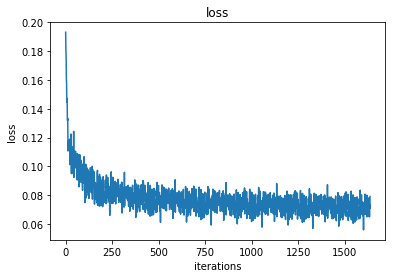

Epoch: 61/200... Training loss: 0.0740
Epoch: 61/200... Training loss: 0.0742
Epoch: 61/200... Training loss: 0.0717
Epoch: 61/200... Training loss: 0.0741
Epoch: 61/200... Training loss: 0.0715
Epoch: 61/200... Training loss: 0.0743
Epoch: 61/200... Training loss: 0.0698
Epoch: 61/200... Training loss: 0.0713
Epoch: 61/200... Training loss: 0.0796
Epoch: 61/200... Training loss: 0.0710
Epoch: 61/200... Training loss: 0.0720
Epoch: 61/200... Training loss: 0.0761
Epoch: 61/200... Training loss: 0.0702
Epoch: 61/200... Training loss: 0.0665
Epoch: 61/200... Training loss: 0.0722
Epoch: 61/200... Training loss: 0.0707
Epoch: 61/200... Training loss: 0.0707
Epoch: 61/200... Training loss: 0.0728
Epoch: 61/200... Training loss: 0.0731
Epoch: 61/200... Training loss: 0.0738
Epoch: 61/200... Training loss: 0.0730
Epoch: 61/200... Training loss: 0.0790
Epoch: 61/200... Training loss: 0.0758
Epoch: 61/200... Training loss: 0.0676
Epoch: 61/200... Training loss: 0.0751
Epoch: 61/200... Training

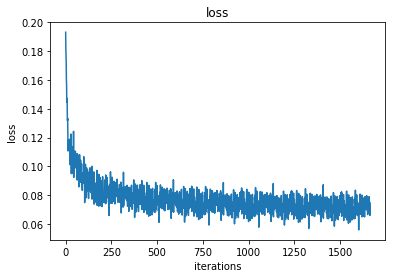

Epoch: 62/200... Training loss: 0.0662
Epoch: 62/200... Training loss: 0.0794
Epoch: 62/200... Training loss: 0.0720
Epoch: 62/200... Training loss: 0.0783
Epoch: 62/200... Training loss: 0.0614
Epoch: 62/200... Training loss: 0.0709
Epoch: 62/200... Training loss: 0.0770
Epoch: 62/200... Training loss: 0.0757
Epoch: 62/200... Training loss: 0.0648
Epoch: 62/200... Training loss: 0.0691
Epoch: 62/200... Training loss: 0.0754
Epoch: 62/200... Training loss: 0.0693
Epoch: 62/200... Training loss: 0.0710
Epoch: 62/200... Training loss: 0.0704
Epoch: 62/200... Training loss: 0.0739
Epoch: 62/200... Training loss: 0.0654
Epoch: 62/200... Training loss: 0.0860
Epoch: 62/200... Training loss: 0.0632
Epoch: 62/200... Training loss: 0.0763
Epoch: 62/200... Training loss: 0.0728
Epoch: 62/200... Training loss: 0.0724
Epoch: 62/200... Training loss: 0.0687
Epoch: 62/200... Training loss: 0.0752
Epoch: 62/200... Training loss: 0.0713
Epoch: 62/200... Training loss: 0.0705
Epoch: 62/200... Training

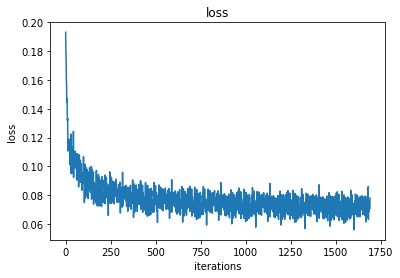

Epoch: 63/200... Training loss: 0.0733
Epoch: 63/200... Training loss: 0.0731
Epoch: 63/200... Training loss: 0.0739
Epoch: 63/200... Training loss: 0.0696
Epoch: 63/200... Training loss: 0.0720
Epoch: 63/200... Training loss: 0.0730
Epoch: 63/200... Training loss: 0.0754
Epoch: 63/200... Training loss: 0.0670
Epoch: 63/200... Training loss: 0.0774
Epoch: 63/200... Training loss: 0.0777
Epoch: 63/200... Training loss: 0.0705
Epoch: 63/200... Training loss: 0.0653
Epoch: 63/200... Training loss: 0.0638
Epoch: 63/200... Training loss: 0.0750
Epoch: 63/200... Training loss: 0.0769
Epoch: 63/200... Training loss: 0.0687
Epoch: 63/200... Training loss: 0.0701
Epoch: 63/200... Training loss: 0.0762
Epoch: 63/200... Training loss: 0.0624
Epoch: 63/200... Training loss: 0.0705
Epoch: 63/200... Training loss: 0.0714
Epoch: 63/200... Training loss: 0.0709
Epoch: 63/200... Training loss: 0.0759
Epoch: 63/200... Training loss: 0.0752
Epoch: 63/200... Training loss: 0.0683
Epoch: 63/200... Training

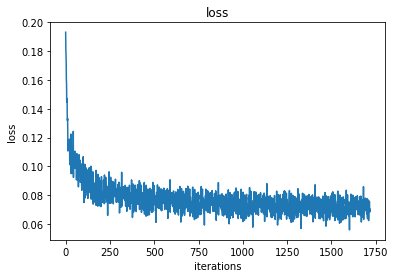

Epoch: 64/200... Training loss: 0.0742
Epoch: 64/200... Training loss: 0.0726
Epoch: 64/200... Training loss: 0.0642
Epoch: 64/200... Training loss: 0.0669
Epoch: 64/200... Training loss: 0.0724
Epoch: 64/200... Training loss: 0.0747
Epoch: 64/200... Training loss: 0.0787
Epoch: 64/200... Training loss: 0.0727
Epoch: 64/200... Training loss: 0.0707
Epoch: 64/200... Training loss: 0.0629
Epoch: 64/200... Training loss: 0.0614
Epoch: 64/200... Training loss: 0.0716
Epoch: 64/200... Training loss: 0.0721
Epoch: 64/200... Training loss: 0.0715
Epoch: 64/200... Training loss: 0.0716
Epoch: 64/200... Training loss: 0.0671
Epoch: 64/200... Training loss: 0.0730
Epoch: 64/200... Training loss: 0.0682
Epoch: 64/200... Training loss: 0.0815
Epoch: 64/200... Training loss: 0.0707
Epoch: 64/200... Training loss: 0.0739
Epoch: 64/200... Training loss: 0.0705
Epoch: 64/200... Training loss: 0.0702
Epoch: 64/200... Training loss: 0.0582
Epoch: 64/200... Training loss: 0.0657
Epoch: 64/200... Training

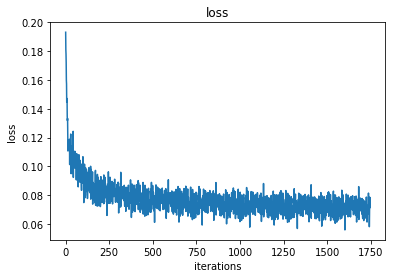

Epoch: 65/200... Training loss: 0.0715
Epoch: 65/200... Training loss: 0.0621
Epoch: 65/200... Training loss: 0.0646
Epoch: 65/200... Training loss: 0.0676
Epoch: 65/200... Training loss: 0.0635
Epoch: 65/200... Training loss: 0.0768
Epoch: 65/200... Training loss: 0.0640
Epoch: 65/200... Training loss: 0.0661
Epoch: 65/200... Training loss: 0.0677
Epoch: 65/200... Training loss: 0.0718
Epoch: 65/200... Training loss: 0.0782
Epoch: 65/200... Training loss: 0.0648
Epoch: 65/200... Training loss: 0.0731
Epoch: 65/200... Training loss: 0.0749
Epoch: 65/200... Training loss: 0.0755
Epoch: 65/200... Training loss: 0.0718
Epoch: 65/200... Training loss: 0.0626
Epoch: 65/200... Training loss: 0.0725
Epoch: 65/200... Training loss: 0.0761
Epoch: 65/200... Training loss: 0.0712
Epoch: 65/200... Training loss: 0.0694
Epoch: 65/200... Training loss: 0.0655
Epoch: 65/200... Training loss: 0.0702
Epoch: 65/200... Training loss: 0.0691
Epoch: 65/200... Training loss: 0.0791
Epoch: 65/200... Training

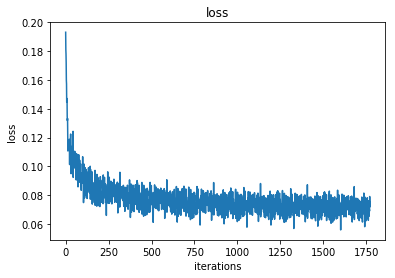

Epoch: 66/200... Training loss: 0.0753
Epoch: 66/200... Training loss: 0.0677
Epoch: 66/200... Training loss: 0.0690
Epoch: 66/200... Training loss: 0.0805
Epoch: 66/200... Training loss: 0.0703
Epoch: 66/200... Training loss: 0.0733
Epoch: 66/200... Training loss: 0.0736
Epoch: 66/200... Training loss: 0.0819
Epoch: 66/200... Training loss: 0.0649
Epoch: 66/200... Training loss: 0.0807
Epoch: 66/200... Training loss: 0.0727
Epoch: 66/200... Training loss: 0.0710
Epoch: 66/200... Training loss: 0.0778
Epoch: 66/200... Training loss: 0.0695
Epoch: 66/200... Training loss: 0.0750
Epoch: 66/200... Training loss: 0.0789
Epoch: 66/200... Training loss: 0.0711
Epoch: 66/200... Training loss: 0.0713
Epoch: 66/200... Training loss: 0.0799
Epoch: 66/200... Training loss: 0.0622
Epoch: 66/200... Training loss: 0.0681
Epoch: 66/200... Training loss: 0.0651
Epoch: 66/200... Training loss: 0.0758
Epoch: 66/200... Training loss: 0.0717
Epoch: 66/200... Training loss: 0.0713
Epoch: 66/200... Training

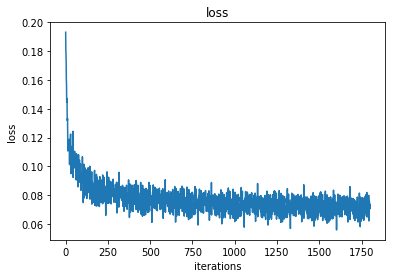

Epoch: 67/200... Training loss: 0.0695
Epoch: 67/200... Training loss: 0.0695
Epoch: 67/200... Training loss: 0.0682
Epoch: 67/200... Training loss: 0.0679
Epoch: 67/200... Training loss: 0.0643
Epoch: 67/200... Training loss: 0.0696
Epoch: 67/200... Training loss: 0.0707
Epoch: 67/200... Training loss: 0.0815
Epoch: 67/200... Training loss: 0.0825
Epoch: 67/200... Training loss: 0.0618
Epoch: 67/200... Training loss: 0.0797
Epoch: 67/200... Training loss: 0.0708
Epoch: 67/200... Training loss: 0.0720
Epoch: 67/200... Training loss: 0.0728
Epoch: 67/200... Training loss: 0.0729
Epoch: 67/200... Training loss: 0.0694
Epoch: 67/200... Training loss: 0.0704
Epoch: 67/200... Training loss: 0.0758
Epoch: 67/200... Training loss: 0.0597
Epoch: 67/200... Training loss: 0.0795
Epoch: 67/200... Training loss: 0.0731
Epoch: 67/200... Training loss: 0.0645
Epoch: 67/200... Training loss: 0.0721
Epoch: 67/200... Training loss: 0.0661
Epoch: 67/200... Training loss: 0.0762
Epoch: 67/200... Training

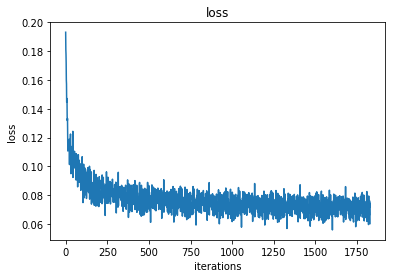

Epoch: 68/200... Training loss: 0.0779
Epoch: 68/200... Training loss: 0.0658
Epoch: 68/200... Training loss: 0.0694
Epoch: 68/200... Training loss: 0.0763
Epoch: 68/200... Training loss: 0.0738
Epoch: 68/200... Training loss: 0.0712
Epoch: 68/200... Training loss: 0.0709
Epoch: 68/200... Training loss: 0.0713
Epoch: 68/200... Training loss: 0.0621
Epoch: 68/200... Training loss: 0.0627
Epoch: 68/200... Training loss: 0.0735
Epoch: 68/200... Training loss: 0.0784
Epoch: 68/200... Training loss: 0.0698
Epoch: 68/200... Training loss: 0.0695
Epoch: 68/200... Training loss: 0.0683
Epoch: 68/200... Training loss: 0.0654
Epoch: 68/200... Training loss: 0.0688
Epoch: 68/200... Training loss: 0.0680
Epoch: 68/200... Training loss: 0.0713
Epoch: 68/200... Training loss: 0.0704
Epoch: 68/200... Training loss: 0.0678
Epoch: 68/200... Training loss: 0.0630
Epoch: 68/200... Training loss: 0.0767
Epoch: 68/200... Training loss: 0.0756
Epoch: 68/200... Training loss: 0.0735
Epoch: 68/200... Training

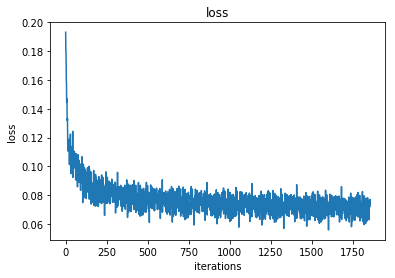

Epoch: 69/200... Training loss: 0.0634
Epoch: 69/200... Training loss: 0.0833
Epoch: 69/200... Training loss: 0.0653
Epoch: 69/200... Training loss: 0.0757
Epoch: 69/200... Training loss: 0.0712
Epoch: 69/200... Training loss: 0.0688
Epoch: 69/200... Training loss: 0.0744
Epoch: 69/200... Training loss: 0.0717
Epoch: 69/200... Training loss: 0.0795
Epoch: 69/200... Training loss: 0.0665
Epoch: 69/200... Training loss: 0.0751
Epoch: 69/200... Training loss: 0.0686
Epoch: 69/200... Training loss: 0.0695
Epoch: 69/200... Training loss: 0.0677
Epoch: 69/200... Training loss: 0.0729
Epoch: 69/200... Training loss: 0.0705
Epoch: 69/200... Training loss: 0.0651
Epoch: 69/200... Training loss: 0.0661
Epoch: 69/200... Training loss: 0.0672
Epoch: 69/200... Training loss: 0.0554
Epoch: 69/200... Training loss: 0.0713
Epoch: 69/200... Training loss: 0.0687
Epoch: 69/200... Training loss: 0.0745
Epoch: 69/200... Training loss: 0.0663
Epoch: 69/200... Training loss: 0.0739
Epoch: 69/200... Training

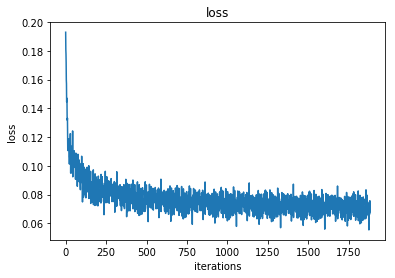

Epoch: 70/200... Training loss: 0.0805
Epoch: 70/200... Training loss: 0.0727
Epoch: 70/200... Training loss: 0.0715
Epoch: 70/200... Training loss: 0.0662
Epoch: 70/200... Training loss: 0.0789
Epoch: 70/200... Training loss: 0.0704
Epoch: 70/200... Training loss: 0.0713
Epoch: 70/200... Training loss: 0.0664
Epoch: 70/200... Training loss: 0.0773
Epoch: 70/200... Training loss: 0.0799
Epoch: 70/200... Training loss: 0.0644
Epoch: 70/200... Training loss: 0.0790
Epoch: 70/200... Training loss: 0.0738
Epoch: 70/200... Training loss: 0.0682
Epoch: 70/200... Training loss: 0.0724
Epoch: 70/200... Training loss: 0.0737
Epoch: 70/200... Training loss: 0.0707
Epoch: 70/200... Training loss: 0.0694
Epoch: 70/200... Training loss: 0.0714
Epoch: 70/200... Training loss: 0.0651
Epoch: 70/200... Training loss: 0.0657
Epoch: 70/200... Training loss: 0.0783
Epoch: 70/200... Training loss: 0.0720
Epoch: 70/200... Training loss: 0.0709
Epoch: 70/200... Training loss: 0.0643
Epoch: 70/200... Training

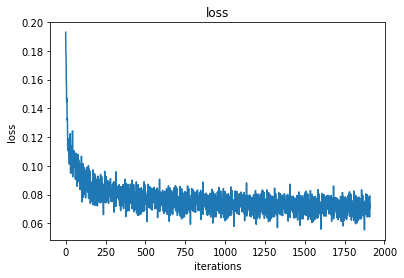

Epoch: 71/200... Training loss: 0.0730
Epoch: 71/200... Training loss: 0.0739
Epoch: 71/200... Training loss: 0.0709
Epoch: 71/200... Training loss: 0.0739
Epoch: 71/200... Training loss: 0.0713
Epoch: 71/200... Training loss: 0.0740
Epoch: 71/200... Training loss: 0.0690
Epoch: 71/200... Training loss: 0.0711
Epoch: 71/200... Training loss: 0.0791
Epoch: 71/200... Training loss: 0.0701
Epoch: 71/200... Training loss: 0.0719
Epoch: 71/200... Training loss: 0.0754
Epoch: 71/200... Training loss: 0.0697
Epoch: 71/200... Training loss: 0.0659
Epoch: 71/200... Training loss: 0.0708
Epoch: 71/200... Training loss: 0.0703
Epoch: 71/200... Training loss: 0.0706
Epoch: 71/200... Training loss: 0.0726
Epoch: 71/200... Training loss: 0.0722
Epoch: 71/200... Training loss: 0.0735
Epoch: 71/200... Training loss: 0.0722
Epoch: 71/200... Training loss: 0.0783
Epoch: 71/200... Training loss: 0.0755
Epoch: 71/200... Training loss: 0.0670
Epoch: 71/200... Training loss: 0.0740
Epoch: 71/200... Training

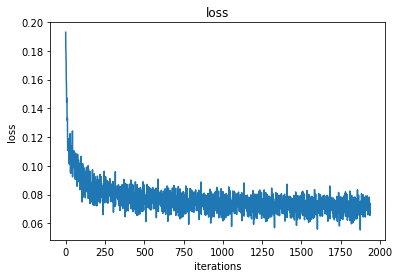

Epoch: 72/200... Training loss: 0.0650
Epoch: 72/200... Training loss: 0.0794
Epoch: 72/200... Training loss: 0.0712
Epoch: 72/200... Training loss: 0.0776
Epoch: 72/200... Training loss: 0.0605
Epoch: 72/200... Training loss: 0.0708
Epoch: 72/200... Training loss: 0.0764
Epoch: 72/200... Training loss: 0.0752
Epoch: 72/200... Training loss: 0.0645
Epoch: 72/200... Training loss: 0.0679
Epoch: 72/200... Training loss: 0.0749
Epoch: 72/200... Training loss: 0.0684
Epoch: 72/200... Training loss: 0.0707
Epoch: 72/200... Training loss: 0.0703
Epoch: 72/200... Training loss: 0.0732
Epoch: 72/200... Training loss: 0.0648
Epoch: 72/200... Training loss: 0.0854
Epoch: 72/200... Training loss: 0.0629
Epoch: 72/200... Training loss: 0.0759
Epoch: 72/200... Training loss: 0.0723
Epoch: 72/200... Training loss: 0.0721
Epoch: 72/200... Training loss: 0.0678
Epoch: 72/200... Training loss: 0.0746
Epoch: 72/200... Training loss: 0.0711
Epoch: 72/200... Training loss: 0.0698
Epoch: 72/200... Training

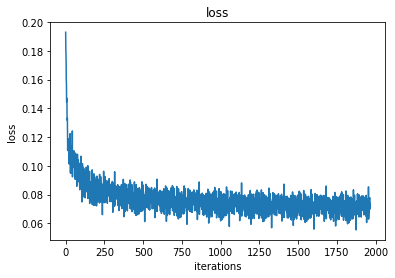

Epoch: 73/200... Training loss: 0.0726
Epoch: 73/200... Training loss: 0.0726
Epoch: 73/200... Training loss: 0.0737
Epoch: 73/200... Training loss: 0.0697
Epoch: 73/200... Training loss: 0.0718
Epoch: 73/200... Training loss: 0.0727
Epoch: 73/200... Training loss: 0.0747
Epoch: 73/200... Training loss: 0.0665
Epoch: 73/200... Training loss: 0.0771
Epoch: 73/200... Training loss: 0.0773
Epoch: 73/200... Training loss: 0.0699
Epoch: 73/200... Training loss: 0.0651
Epoch: 73/200... Training loss: 0.0635
Epoch: 73/200... Training loss: 0.0746
Epoch: 73/200... Training loss: 0.0762
Epoch: 73/200... Training loss: 0.0681
Epoch: 73/200... Training loss: 0.0694
Epoch: 73/200... Training loss: 0.0756
Epoch: 73/200... Training loss: 0.0621
Epoch: 73/200... Training loss: 0.0700
Epoch: 73/200... Training loss: 0.0708
Epoch: 73/200... Training loss: 0.0705
Epoch: 73/200... Training loss: 0.0754
Epoch: 73/200... Training loss: 0.0747
Epoch: 73/200... Training loss: 0.0678
Epoch: 73/200... Training

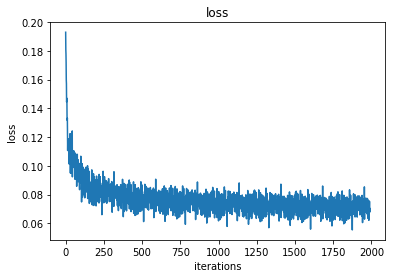

Epoch: 74/200... Training loss: 0.0740
Epoch: 74/200... Training loss: 0.0721
Epoch: 74/200... Training loss: 0.0636
Epoch: 74/200... Training loss: 0.0665
Epoch: 74/200... Training loss: 0.0718
Epoch: 74/200... Training loss: 0.0745
Epoch: 74/200... Training loss: 0.0783
Epoch: 74/200... Training loss: 0.0726
Epoch: 74/200... Training loss: 0.0701
Epoch: 74/200... Training loss: 0.0621
Epoch: 74/200... Training loss: 0.0614
Epoch: 74/200... Training loss: 0.0709
Epoch: 74/200... Training loss: 0.0721
Epoch: 74/200... Training loss: 0.0706
Epoch: 74/200... Training loss: 0.0716
Epoch: 74/200... Training loss: 0.0666
Epoch: 74/200... Training loss: 0.0719
Epoch: 74/200... Training loss: 0.0680
Epoch: 74/200... Training loss: 0.0810
Epoch: 74/200... Training loss: 0.0704
Epoch: 74/200... Training loss: 0.0733
Epoch: 74/200... Training loss: 0.0701
Epoch: 74/200... Training loss: 0.0692
Epoch: 74/200... Training loss: 0.0578
Epoch: 74/200... Training loss: 0.0653
Epoch: 74/200... Training

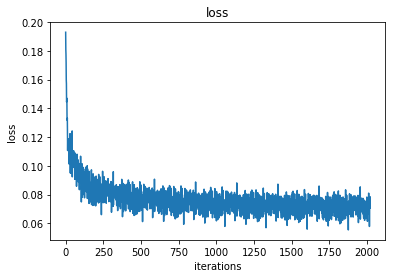

Epoch: 75/200... Training loss: 0.0711
Epoch: 75/200... Training loss: 0.0615
Epoch: 75/200... Training loss: 0.0645
Epoch: 75/200... Training loss: 0.0673
Epoch: 75/200... Training loss: 0.0636
Epoch: 75/200... Training loss: 0.0760
Epoch: 75/200... Training loss: 0.0643
Epoch: 75/200... Training loss: 0.0661
Epoch: 75/200... Training loss: 0.0669
Epoch: 75/200... Training loss: 0.0714
Epoch: 75/200... Training loss: 0.0777
Epoch: 75/200... Training loss: 0.0646
Epoch: 75/200... Training loss: 0.0726
Epoch: 75/200... Training loss: 0.0746
Epoch: 75/200... Training loss: 0.0749
Epoch: 75/200... Training loss: 0.0713
Epoch: 75/200... Training loss: 0.0621
Epoch: 75/200... Training loss: 0.0723
Epoch: 75/200... Training loss: 0.0754
Epoch: 75/200... Training loss: 0.0706
Epoch: 75/200... Training loss: 0.0691
Epoch: 75/200... Training loss: 0.0649
Epoch: 75/200... Training loss: 0.0693
Epoch: 75/200... Training loss: 0.0688
Epoch: 75/200... Training loss: 0.0787
Epoch: 75/200... Training

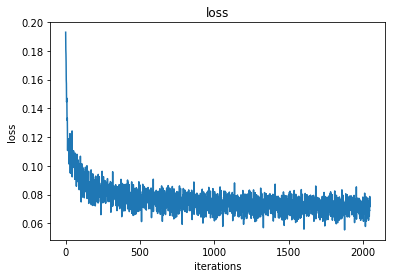

Epoch: 76/200... Training loss: 0.0750
Epoch: 76/200... Training loss: 0.0671
Epoch: 76/200... Training loss: 0.0683
Epoch: 76/200... Training loss: 0.0802
Epoch: 76/200... Training loss: 0.0696
Epoch: 76/200... Training loss: 0.0727
Epoch: 76/200... Training loss: 0.0741
Epoch: 76/200... Training loss: 0.0815
Epoch: 76/200... Training loss: 0.0646
Epoch: 76/200... Training loss: 0.0799
Epoch: 76/200... Training loss: 0.0717
Epoch: 76/200... Training loss: 0.0708
Epoch: 76/200... Training loss: 0.0772
Epoch: 76/200... Training loss: 0.0692
Epoch: 76/200... Training loss: 0.0741
Epoch: 76/200... Training loss: 0.0790
Epoch: 76/200... Training loss: 0.0708
Epoch: 76/200... Training loss: 0.0709
Epoch: 76/200... Training loss: 0.0796
Epoch: 76/200... Training loss: 0.0613
Epoch: 76/200... Training loss: 0.0676
Epoch: 76/200... Training loss: 0.0650
Epoch: 76/200... Training loss: 0.0754
Epoch: 76/200... Training loss: 0.0712
Epoch: 76/200... Training loss: 0.0711
Epoch: 76/200... Training

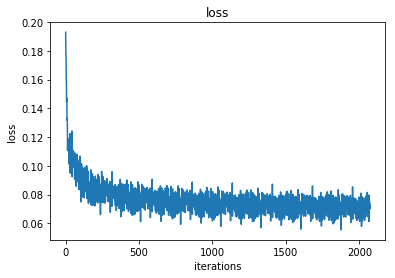

Epoch: 77/200... Training loss: 0.0690
Epoch: 77/200... Training loss: 0.0687
Epoch: 77/200... Training loss: 0.0681
Epoch: 77/200... Training loss: 0.0675
Epoch: 77/200... Training loss: 0.0638
Epoch: 77/200... Training loss: 0.0691
Epoch: 77/200... Training loss: 0.0705
Epoch: 77/200... Training loss: 0.0808
Epoch: 77/200... Training loss: 0.0811
Epoch: 77/200... Training loss: 0.0614
Epoch: 77/200... Training loss: 0.0793
Epoch: 77/200... Training loss: 0.0703
Epoch: 77/200... Training loss: 0.0717
Epoch: 77/200... Training loss: 0.0719
Epoch: 77/200... Training loss: 0.0720
Epoch: 77/200... Training loss: 0.0685
Epoch: 77/200... Training loss: 0.0696
Epoch: 77/200... Training loss: 0.0758
Epoch: 77/200... Training loss: 0.0596
Epoch: 77/200... Training loss: 0.0793
Epoch: 77/200... Training loss: 0.0724
Epoch: 77/200... Training loss: 0.0638
Epoch: 77/200... Training loss: 0.0719
Epoch: 77/200... Training loss: 0.0657
Epoch: 77/200... Training loss: 0.0757
Epoch: 77/200... Training

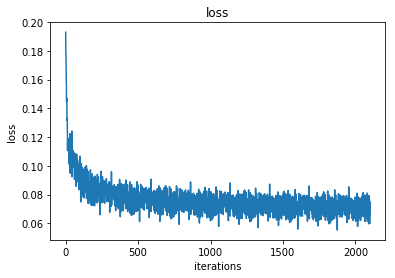

Epoch: 78/200... Training loss: 0.0775
Epoch: 78/200... Training loss: 0.0655
Epoch: 78/200... Training loss: 0.0693
Epoch: 78/200... Training loss: 0.0755
Epoch: 78/200... Training loss: 0.0732
Epoch: 78/200... Training loss: 0.0709
Epoch: 78/200... Training loss: 0.0703
Epoch: 78/200... Training loss: 0.0708
Epoch: 78/200... Training loss: 0.0619
Epoch: 78/200... Training loss: 0.0625
Epoch: 78/200... Training loss: 0.0724
Epoch: 78/200... Training loss: 0.0777
Epoch: 78/200... Training loss: 0.0697
Epoch: 78/200... Training loss: 0.0691
Epoch: 78/200... Training loss: 0.0685
Epoch: 78/200... Training loss: 0.0647
Epoch: 78/200... Training loss: 0.0680
Epoch: 78/200... Training loss: 0.0679
Epoch: 78/200... Training loss: 0.0707
Epoch: 78/200... Training loss: 0.0699
Epoch: 78/200... Training loss: 0.0674
Epoch: 78/200... Training loss: 0.0628
Epoch: 78/200... Training loss: 0.0762
Epoch: 78/200... Training loss: 0.0749
Epoch: 78/200... Training loss: 0.0732
Epoch: 78/200... Training

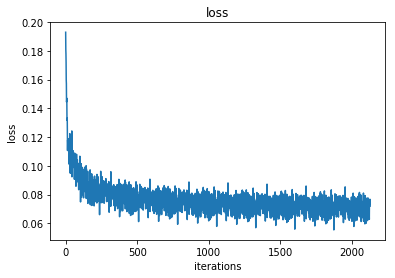

Epoch: 79/200... Training loss: 0.0633
Epoch: 79/200... Training loss: 0.0831
Epoch: 79/200... Training loss: 0.0649
Epoch: 79/200... Training loss: 0.0746
Epoch: 79/200... Training loss: 0.0706
Epoch: 79/200... Training loss: 0.0686
Epoch: 79/200... Training loss: 0.0738
Epoch: 79/200... Training loss: 0.0713
Epoch: 79/200... Training loss: 0.0789
Epoch: 79/200... Training loss: 0.0661
Epoch: 79/200... Training loss: 0.0749
Epoch: 79/200... Training loss: 0.0681
Epoch: 79/200... Training loss: 0.0692
Epoch: 79/200... Training loss: 0.0677
Epoch: 79/200... Training loss: 0.0728
Epoch: 79/200... Training loss: 0.0699
Epoch: 79/200... Training loss: 0.0640
Epoch: 79/200... Training loss: 0.0663
Epoch: 79/200... Training loss: 0.0670
Epoch: 79/200... Training loss: 0.0551
Epoch: 79/200... Training loss: 0.0709
Epoch: 79/200... Training loss: 0.0683
Epoch: 79/200... Training loss: 0.0739
Epoch: 79/200... Training loss: 0.0658
Epoch: 79/200... Training loss: 0.0736
Epoch: 79/200... Training

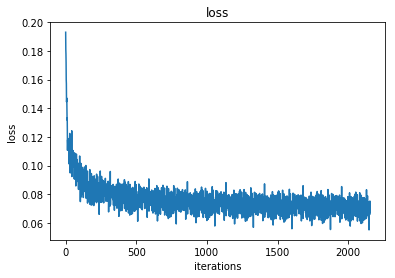

Epoch: 80/200... Training loss: 0.0800
Epoch: 80/200... Training loss: 0.0723
Epoch: 80/200... Training loss: 0.0712
Epoch: 80/200... Training loss: 0.0658
Epoch: 80/200... Training loss: 0.0786
Epoch: 80/200... Training loss: 0.0704
Epoch: 80/200... Training loss: 0.0711
Epoch: 80/200... Training loss: 0.0659
Epoch: 80/200... Training loss: 0.0768
Epoch: 80/200... Training loss: 0.0789
Epoch: 80/200... Training loss: 0.0643
Epoch: 80/200... Training loss: 0.0782
Epoch: 80/200... Training loss: 0.0729
Epoch: 80/200... Training loss: 0.0682
Epoch: 80/200... Training loss: 0.0718
Epoch: 80/200... Training loss: 0.0728
Epoch: 80/200... Training loss: 0.0706
Epoch: 80/200... Training loss: 0.0688
Epoch: 80/200... Training loss: 0.0707
Epoch: 80/200... Training loss: 0.0646
Epoch: 80/200... Training loss: 0.0654
Epoch: 80/200... Training loss: 0.0775
Epoch: 80/200... Training loss: 0.0714
Epoch: 80/200... Training loss: 0.0699
Epoch: 80/200... Training loss: 0.0643
Epoch: 80/200... Training

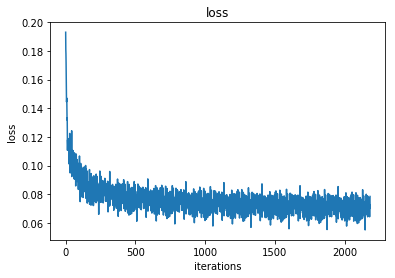

Epoch: 81/200... Training loss: 0.0725
Epoch: 81/200... Training loss: 0.0735
Epoch: 81/200... Training loss: 0.0707
Epoch: 81/200... Training loss: 0.0734
Epoch: 81/200... Training loss: 0.0705
Epoch: 81/200... Training loss: 0.0739
Epoch: 81/200... Training loss: 0.0686
Epoch: 81/200... Training loss: 0.0710
Epoch: 81/200... Training loss: 0.0787
Epoch: 81/200... Training loss: 0.0698
Epoch: 81/200... Training loss: 0.0719
Epoch: 81/200... Training loss: 0.0747
Epoch: 81/200... Training loss: 0.0694
Epoch: 81/200... Training loss: 0.0659
Epoch: 81/200... Training loss: 0.0704
Epoch: 81/200... Training loss: 0.0697
Epoch: 81/200... Training loss: 0.0696
Epoch: 81/200... Training loss: 0.0719
Epoch: 81/200... Training loss: 0.0724
Epoch: 81/200... Training loss: 0.0728
Epoch: 81/200... Training loss: 0.0724
Epoch: 81/200... Training loss: 0.0776
Epoch: 81/200... Training loss: 0.0744
Epoch: 81/200... Training loss: 0.0666
Epoch: 81/200... Training loss: 0.0737
Epoch: 81/200... Training

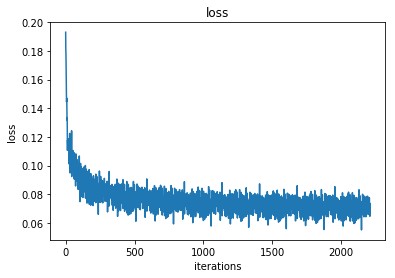

Epoch: 82/200... Training loss: 0.0648
Epoch: 82/200... Training loss: 0.0790
Epoch: 82/200... Training loss: 0.0710
Epoch: 82/200... Training loss: 0.0771
Epoch: 82/200... Training loss: 0.0599
Epoch: 82/200... Training loss: 0.0698
Epoch: 82/200... Training loss: 0.0760
Epoch: 82/200... Training loss: 0.0748
Epoch: 82/200... Training loss: 0.0638
Epoch: 82/200... Training loss: 0.0676
Epoch: 82/200... Training loss: 0.0747
Epoch: 82/200... Training loss: 0.0679
Epoch: 82/200... Training loss: 0.0707
Epoch: 82/200... Training loss: 0.0705
Epoch: 82/200... Training loss: 0.0727
Epoch: 82/200... Training loss: 0.0643
Epoch: 82/200... Training loss: 0.0845
Epoch: 82/200... Training loss: 0.0628
Epoch: 82/200... Training loss: 0.0755
Epoch: 82/200... Training loss: 0.0711
Epoch: 82/200... Training loss: 0.0720
Epoch: 82/200... Training loss: 0.0673
Epoch: 82/200... Training loss: 0.0738
Epoch: 82/200... Training loss: 0.0700
Epoch: 82/200... Training loss: 0.0697
Epoch: 82/200... Training

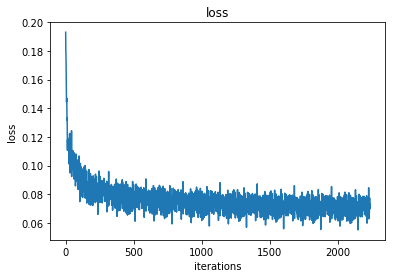

Epoch: 83/200... Training loss: 0.0727
Epoch: 83/200... Training loss: 0.0726
Epoch: 83/200... Training loss: 0.0734
Epoch: 83/200... Training loss: 0.0695
Epoch: 83/200... Training loss: 0.0713
Epoch: 83/200... Training loss: 0.0720
Epoch: 83/200... Training loss: 0.0740
Epoch: 83/200... Training loss: 0.0657
Epoch: 83/200... Training loss: 0.0768
Epoch: 83/200... Training loss: 0.0766
Epoch: 83/200... Training loss: 0.0692
Epoch: 83/200... Training loss: 0.0647
Epoch: 83/200... Training loss: 0.0626
Epoch: 83/200... Training loss: 0.0742
Epoch: 83/200... Training loss: 0.0763
Epoch: 83/200... Training loss: 0.0676
Epoch: 83/200... Training loss: 0.0694
Epoch: 83/200... Training loss: 0.0752
Epoch: 83/200... Training loss: 0.0619
Epoch: 83/200... Training loss: 0.0698
Epoch: 83/200... Training loss: 0.0706
Epoch: 83/200... Training loss: 0.0700
Epoch: 83/200... Training loss: 0.0750
Epoch: 83/200... Training loss: 0.0741
Epoch: 83/200... Training loss: 0.0682
Epoch: 83/200... Training

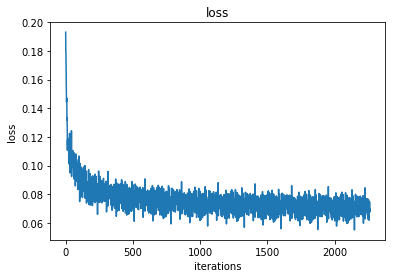

Epoch: 84/200... Training loss: 0.0739
Epoch: 84/200... Training loss: 0.0718
Epoch: 84/200... Training loss: 0.0630
Epoch: 84/200... Training loss: 0.0662
Epoch: 84/200... Training loss: 0.0714
Epoch: 84/200... Training loss: 0.0740
Epoch: 84/200... Training loss: 0.0778
Epoch: 84/200... Training loss: 0.0721
Epoch: 84/200... Training loss: 0.0699
Epoch: 84/200... Training loss: 0.0620
Epoch: 84/200... Training loss: 0.0607
Epoch: 84/200... Training loss: 0.0702
Epoch: 84/200... Training loss: 0.0717
Epoch: 84/200... Training loss: 0.0703
Epoch: 84/200... Training loss: 0.0710
Epoch: 84/200... Training loss: 0.0664
Epoch: 84/200... Training loss: 0.0711
Epoch: 84/200... Training loss: 0.0674
Epoch: 84/200... Training loss: 0.0803
Epoch: 84/200... Training loss: 0.0700
Epoch: 84/200... Training loss: 0.0722
Epoch: 84/200... Training loss: 0.0693
Epoch: 84/200... Training loss: 0.0687
Epoch: 84/200... Training loss: 0.0573
Epoch: 84/200... Training loss: 0.0654
Epoch: 84/200... Training

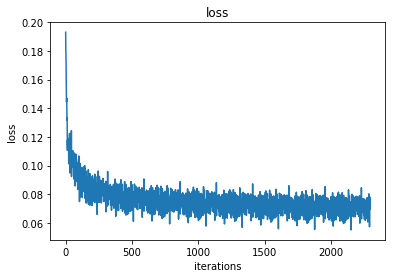

Epoch: 85/200... Training loss: 0.0708
Epoch: 85/200... Training loss: 0.0611
Epoch: 85/200... Training loss: 0.0637
Epoch: 85/200... Training loss: 0.0668
Epoch: 85/200... Training loss: 0.0631
Epoch: 85/200... Training loss: 0.0765
Epoch: 85/200... Training loss: 0.0635
Epoch: 85/200... Training loss: 0.0658
Epoch: 85/200... Training loss: 0.0660
Epoch: 85/200... Training loss: 0.0711
Epoch: 85/200... Training loss: 0.0770
Epoch: 85/200... Training loss: 0.0642
Epoch: 85/200... Training loss: 0.0721
Epoch: 85/200... Training loss: 0.0741
Epoch: 85/200... Training loss: 0.0744
Epoch: 85/200... Training loss: 0.0703
Epoch: 85/200... Training loss: 0.0619
Epoch: 85/200... Training loss: 0.0716
Epoch: 85/200... Training loss: 0.0747
Epoch: 85/200... Training loss: 0.0702
Epoch: 85/200... Training loss: 0.0685
Epoch: 85/200... Training loss: 0.0647
Epoch: 85/200... Training loss: 0.0694
Epoch: 85/200... Training loss: 0.0688
Epoch: 85/200... Training loss: 0.0784
Epoch: 85/200... Training

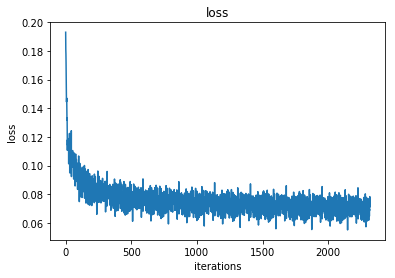

Epoch: 86/200... Training loss: 0.0746
Epoch: 86/200... Training loss: 0.0666
Epoch: 86/200... Training loss: 0.0680
Epoch: 86/200... Training loss: 0.0801
Epoch: 86/200... Training loss: 0.0695
Epoch: 86/200... Training loss: 0.0719
Epoch: 86/200... Training loss: 0.0737
Epoch: 86/200... Training loss: 0.0813
Epoch: 86/200... Training loss: 0.0641
Epoch: 86/200... Training loss: 0.0793
Epoch: 86/200... Training loss: 0.0716
Epoch: 86/200... Training loss: 0.0708
Epoch: 86/200... Training loss: 0.0770
Epoch: 86/200... Training loss: 0.0689
Epoch: 86/200... Training loss: 0.0739
Epoch: 86/200... Training loss: 0.0785
Epoch: 86/200... Training loss: 0.0706
Epoch: 86/200... Training loss: 0.0709
Epoch: 86/200... Training loss: 0.0789
Epoch: 86/200... Training loss: 0.0607
Epoch: 86/200... Training loss: 0.0675
Epoch: 86/200... Training loss: 0.0643
Epoch: 86/200... Training loss: 0.0749
Epoch: 86/200... Training loss: 0.0709
Epoch: 86/200... Training loss: 0.0702
Epoch: 86/200... Training

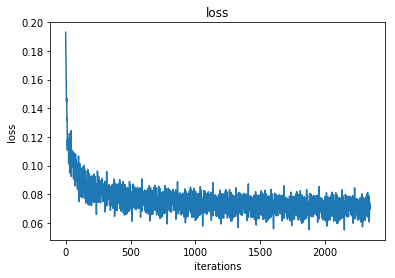

Epoch: 87/200... Training loss: 0.0686
Epoch: 87/200... Training loss: 0.0687
Epoch: 87/200... Training loss: 0.0678
Epoch: 87/200... Training loss: 0.0679
Epoch: 87/200... Training loss: 0.0638
Epoch: 87/200... Training loss: 0.0685
Epoch: 87/200... Training loss: 0.0699
Epoch: 87/200... Training loss: 0.0802
Epoch: 87/200... Training loss: 0.0808
Epoch: 87/200... Training loss: 0.0610
Epoch: 87/200... Training loss: 0.0784
Epoch: 87/200... Training loss: 0.0695
Epoch: 87/200... Training loss: 0.0709
Epoch: 87/200... Training loss: 0.0716
Epoch: 87/200... Training loss: 0.0722
Epoch: 87/200... Training loss: 0.0679
Epoch: 87/200... Training loss: 0.0693
Epoch: 87/200... Training loss: 0.0754
Epoch: 87/200... Training loss: 0.0588
Epoch: 87/200... Training loss: 0.0790
Epoch: 87/200... Training loss: 0.0716
Epoch: 87/200... Training loss: 0.0635
Epoch: 87/200... Training loss: 0.0717
Epoch: 87/200... Training loss: 0.0656
Epoch: 87/200... Training loss: 0.0749
Epoch: 87/200... Training

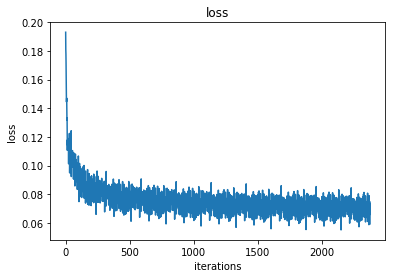

Epoch: 88/200... Training loss: 0.0771
Epoch: 88/200... Training loss: 0.0654
Epoch: 88/200... Training loss: 0.0693
Epoch: 88/200... Training loss: 0.0749
Epoch: 88/200... Training loss: 0.0734
Epoch: 88/200... Training loss: 0.0709
Epoch: 88/200... Training loss: 0.0701
Epoch: 88/200... Training loss: 0.0702
Epoch: 88/200... Training loss: 0.0613
Epoch: 88/200... Training loss: 0.0622
Epoch: 88/200... Training loss: 0.0720
Epoch: 88/200... Training loss: 0.0778
Epoch: 88/200... Training loss: 0.0684
Epoch: 88/200... Training loss: 0.0684
Epoch: 88/200... Training loss: 0.0686
Epoch: 88/200... Training loss: 0.0646
Epoch: 88/200... Training loss: 0.0679
Epoch: 88/200... Training loss: 0.0673
Epoch: 88/200... Training loss: 0.0706


KeyboardInterrupt: 

In [22]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

epochs = 200
total_images = len(train_pairs)
step = 0

r = total_images // batch_size
losses = []

for epoch in range(epochs):
    for ii in range(r):
        step += 1
        d_pairs = train_pairs[ii*batch_size : (ii+1)*batch_size]
        batch, batch_labels, pose_labels = get_batch_data(d_pairs)
        
        '''
        print(np.min(batch[0]), np.max(batch[0]), "BF")
        plt.imshow(batch[0] / 255)
        plt.show()
        
        batch = normalize(batch)
        batch_labels = normalize(batch_labels)
        
        print(batch[0].shape, batch_labels[0].shape)
        print(np.min(batch[0]), np.max(batch[0]))
        
        plt.imshow(denormalize(batch[0]) / 255)
        plt.show()
        
        plt.imshow(denormalize(batch_labels[0]) / 255)
        plt.show()
        '''

        f_dict = {inputs_: batch, targets_: batch_labels, pose_:pose_labels}
        fetches = [train_op, loss_op]
        _, loss = sess.run(fetches, feed_dict=f_dict)
        if step % 100 == 0:
            losses.append(loss)
            print("Epoch: {}/{}...".format(epoch+1, epochs),
            "Training loss: {:.4f}".format(loss))
    plt.plot(losses)
    plt.title('loss')
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.show()

In [23]:

var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'encoder')
saver = tf.train.Saver(var_list)
saver.save(sess, 'model/deep_encoder_pose_car')

'model/deep_encoder_pose_car'

In [24]:
d_pairs = test_pairs[5 * batch_size : 6 * batch_size]
test_batch, test_labels, test_pose = get_batch_data(d_pairs, False)
#d_pairs = train_pairs[5 * batch_size : 6 * batch_size]
#test_batch, test_labels, test_pose = get_batch_data(d_pairs, True)

In [25]:
feed_dict = { inputs_: test_batch, pose_: test_pose}
op = sess.run([res], feed_dict = feed_dict)

In [26]:
j = 20
op = denormalize(op[0])

In [27]:
#op = op.astype(np.uint8)
print(np.min(op), np.max(op))
#print(np.where(op < -0.00001 ))

#print(op[0][0][59])

0.00470415 255.0


In [28]:
op = np.where(op < 0.0,0.0, op)

In [29]:
print(np.min(op), np.max(op))

0.00470415 255.0


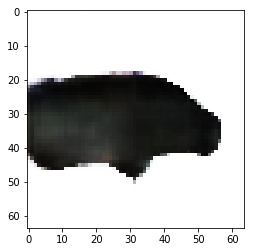

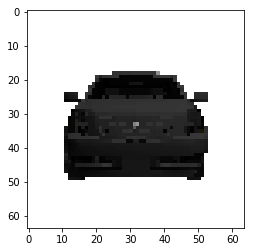

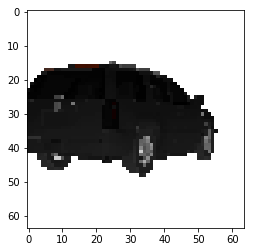

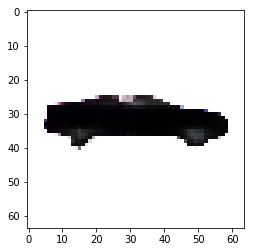

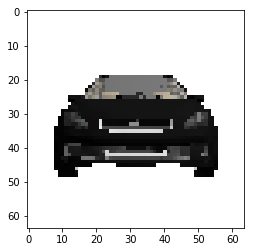

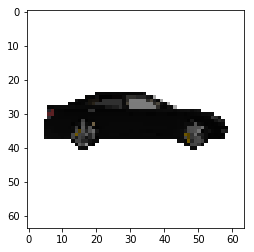

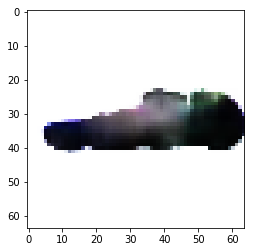

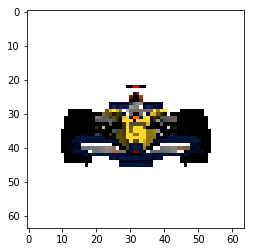

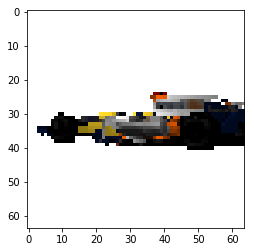

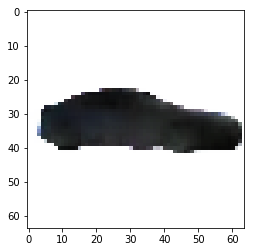

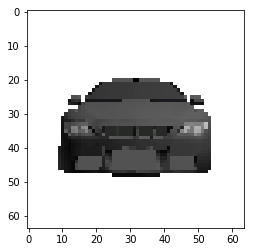

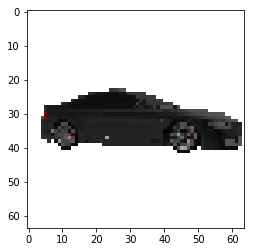

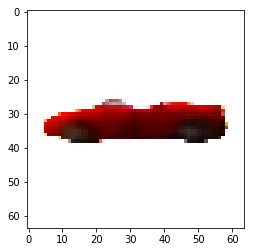

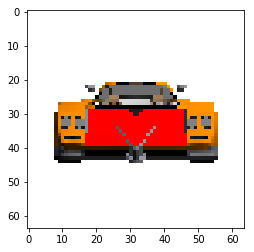

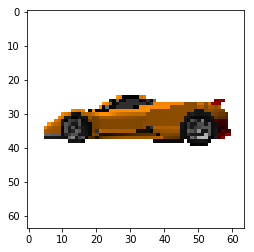

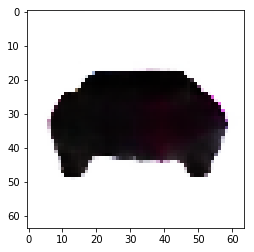

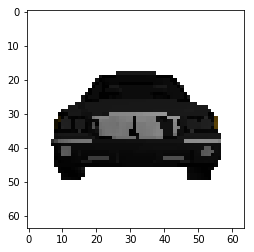

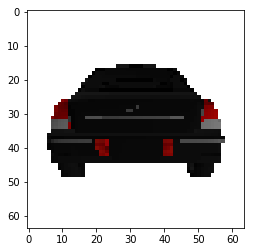

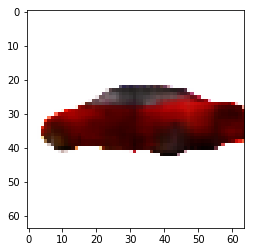

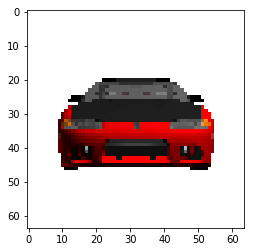

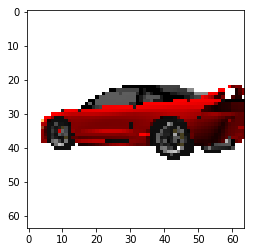

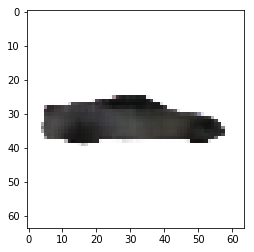

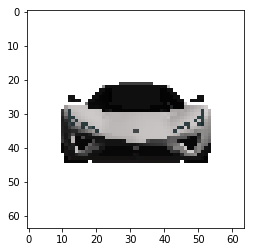

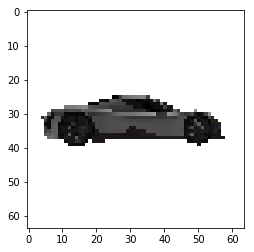

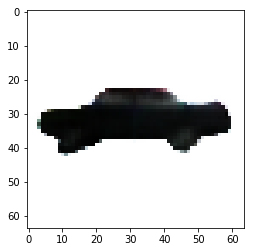

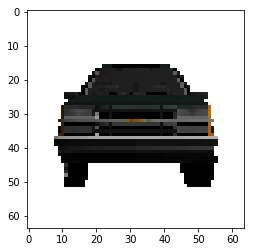

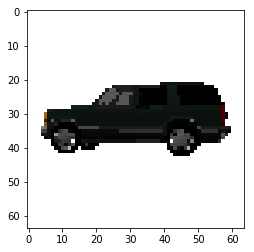

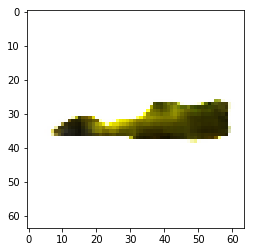

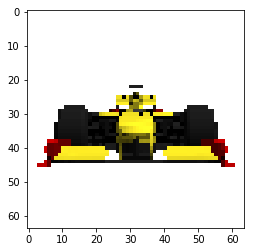

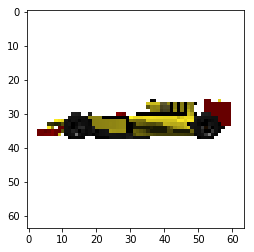

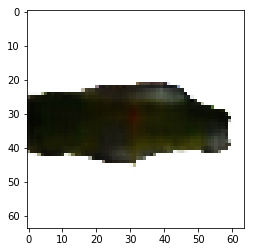

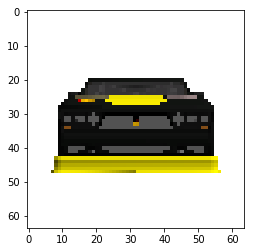

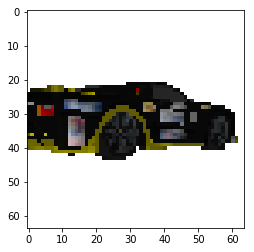

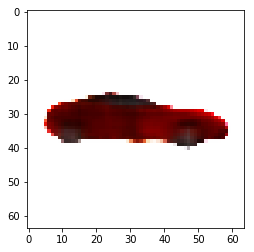

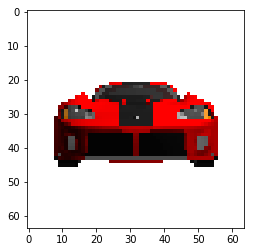

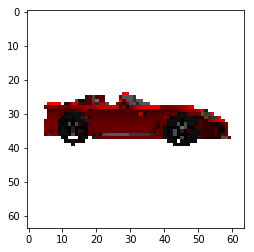

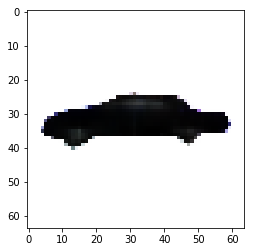

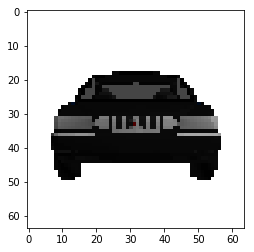

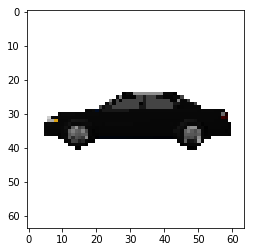

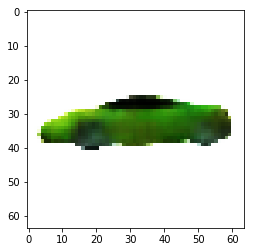

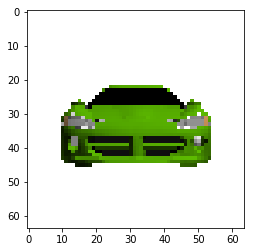

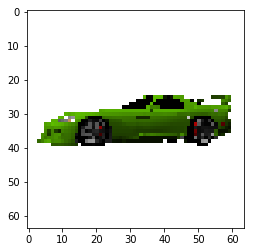

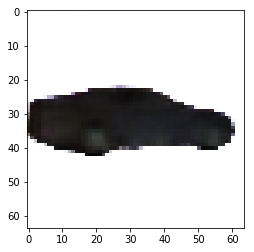

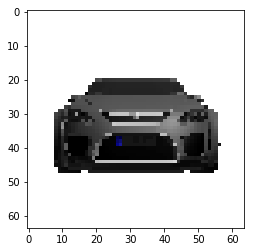

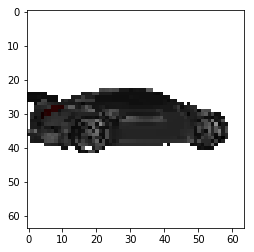

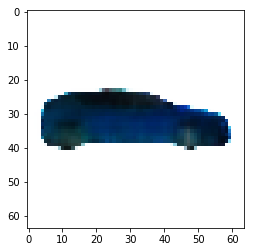

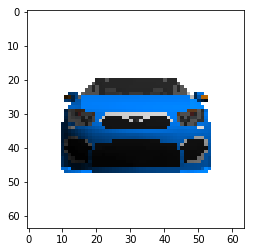

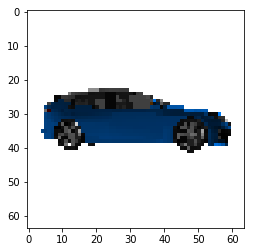

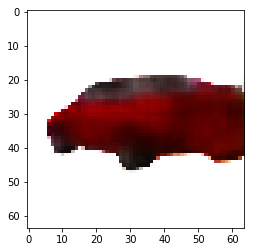

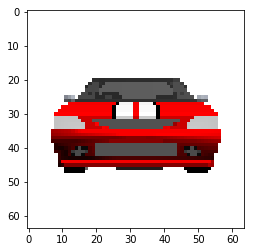

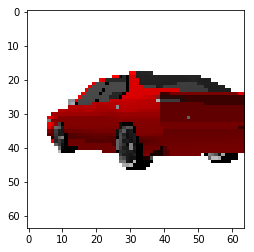

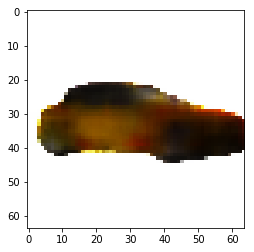

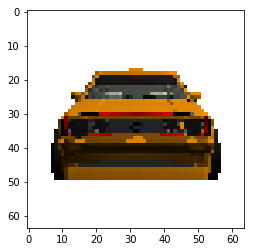

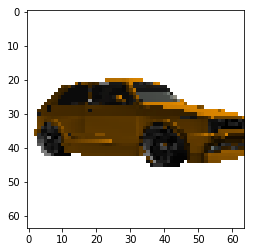

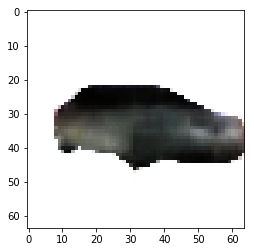

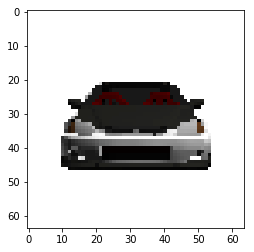

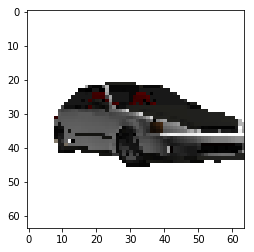

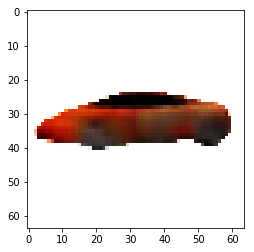

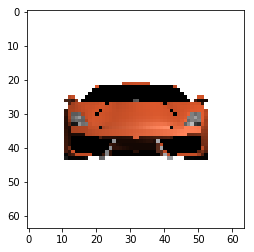

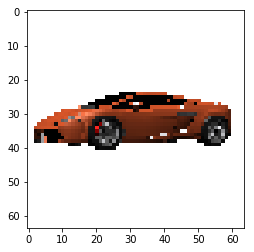

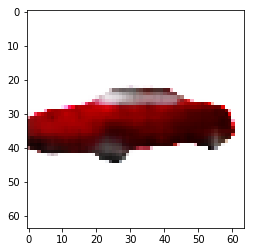

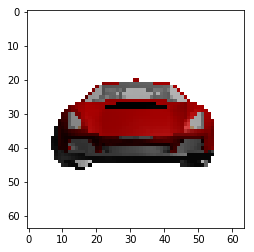

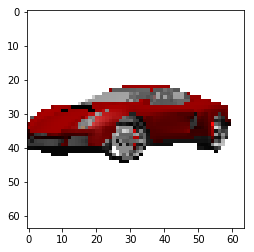

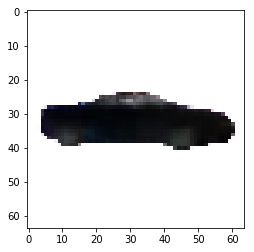

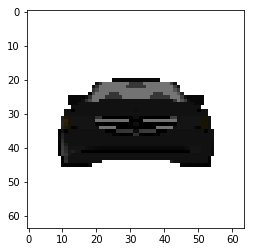

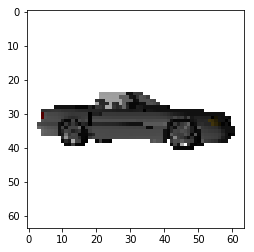

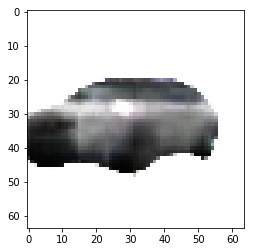

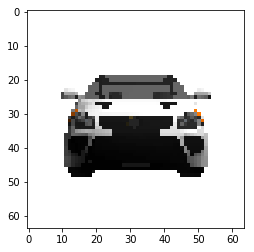

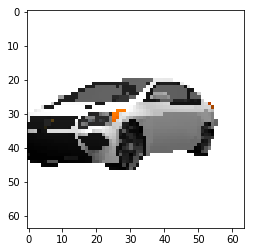

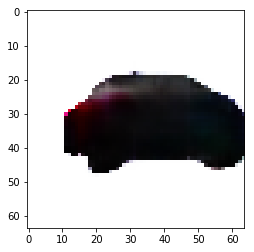

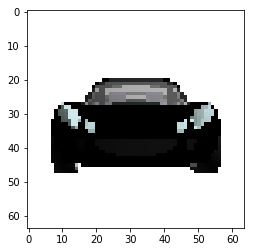

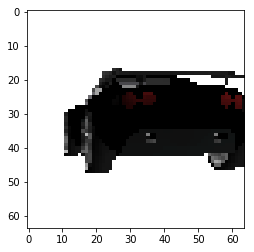

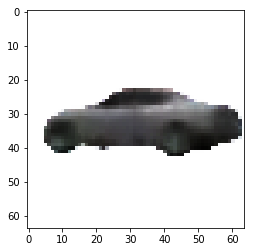

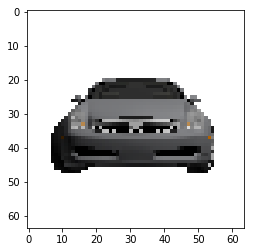

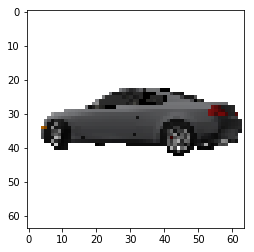

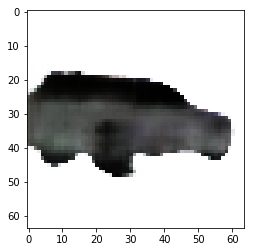

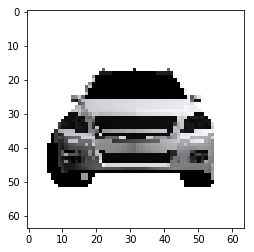

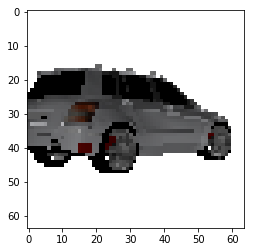

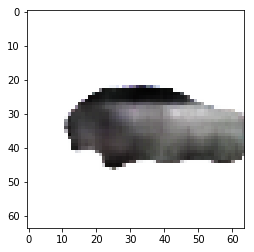

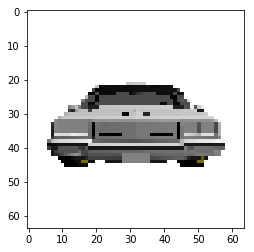

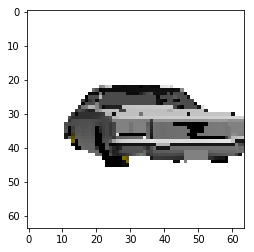

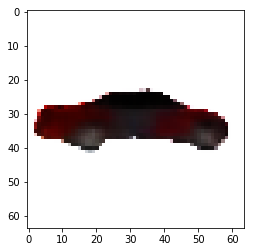

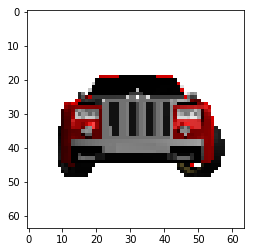

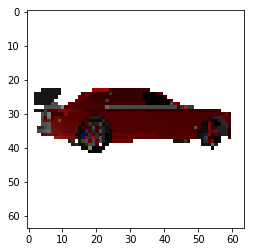

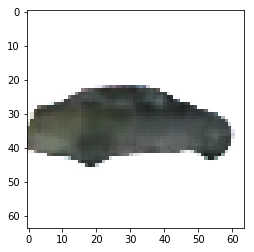

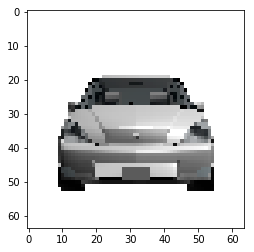

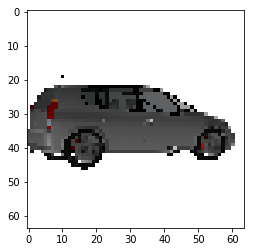

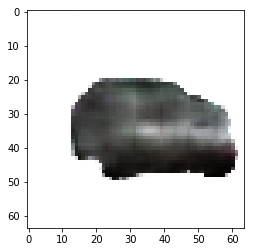

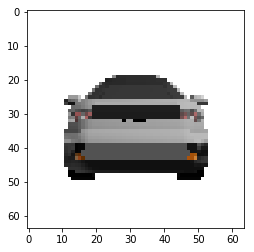

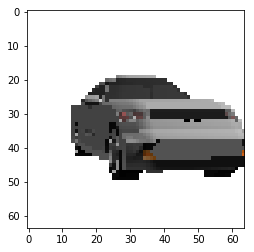

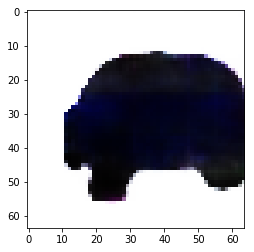

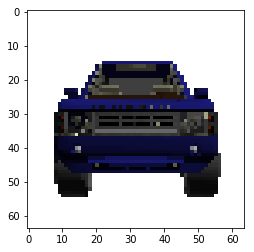

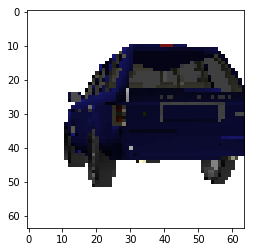

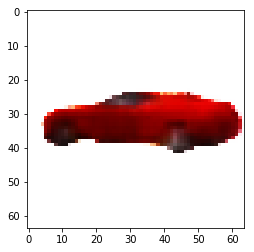

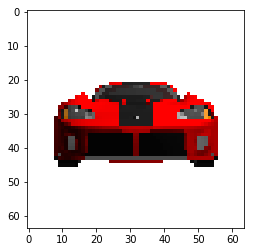

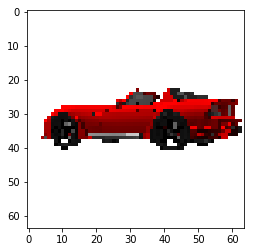

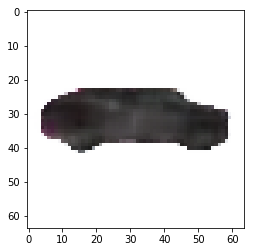

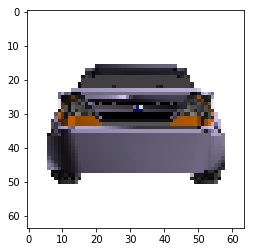

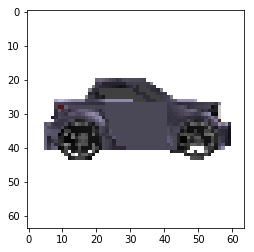

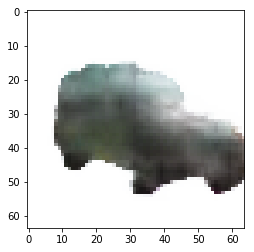

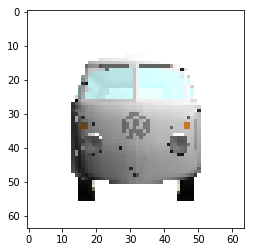

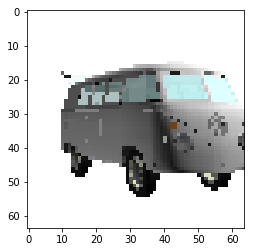

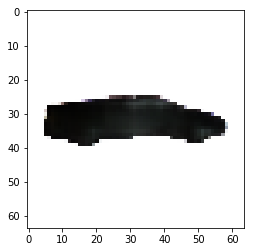

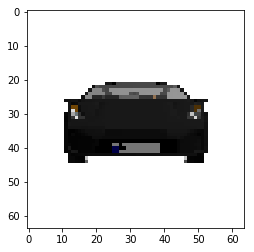

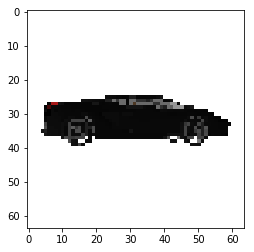

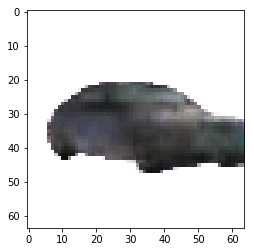

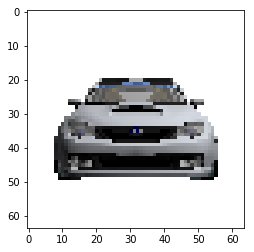

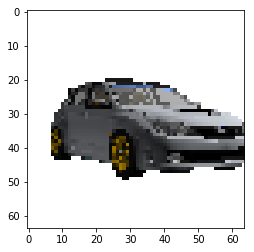

In [30]:
for j in range(batch_size):
    tmp = op[j]
    plt.imshow(tmp / 255)
    plt.show()

    plt.imshow(denormalize(test_batch[j])/255)
    plt.show()

    plt.imshow(denormalize(test_labels[j])/255)
    plt.show()